The scaling of computation in the last decade has allowed to reproduce the behavior and structure of the brain, leading to breakthrought in both machine learning through training artificial neural networks and in neuroscience through simulation. 

Still the complexity of artificial and biological networks remains a mystery, in particular most contemporary models have manually defined connectivity.

However the dynamic generation and deletion of connexion among neurons is crucial to break important mechanisms associated with learning.

In [1]:
import numpy as np
from scipy import sparse

from matplotlib import pyplot as plt
from seaborn import heatmap, color_palette

# Utility functions
from reservoir.utility import show_matrice, show_ei_matrix

# Reservoir functions

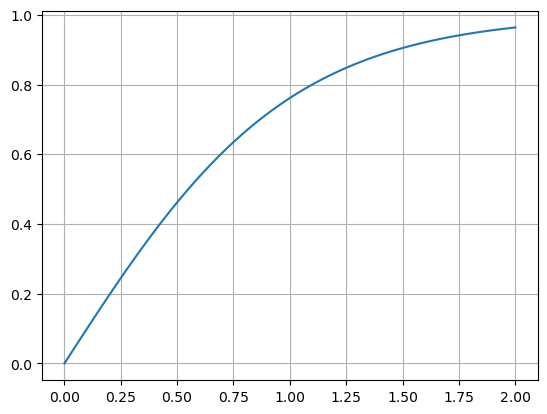

In [2]:
from importlib import reload
import reservoir.reservoir

from reservoir.reservoir import update_ei_reservoir, update_reservoir, ridge_regression, train, run
from reservoir.reservoir import synaptic_scaling, activation_target_definition, constant_synaptic_scaling
from reservoir.activation_functions import tanh, heaviside, sigmoid

reload(reservoir.reservoir)

# SEED
SEED = 3789

# the activation function choosen for the rest of the experiment
# activation_function = lambda x : sigmoid(2*(x-0.5))
activation_function = lambda x : tanh(x)

plt.plot(np.linspace(0, 2, 100), activation_function(np.linspace(0, 2, 100)))
plt.grid()

In [3]:
from scipy.stats import poisson

mu = 100
timesteps = 20000
n_e=100

U = poisson.rvs(mu, size=[timesteps, n_e], random_state = SEED)[np.newaxis].T

# rescale between 0 and 1
inputs1 = (U - U.min()) / (U.max() - U.min())

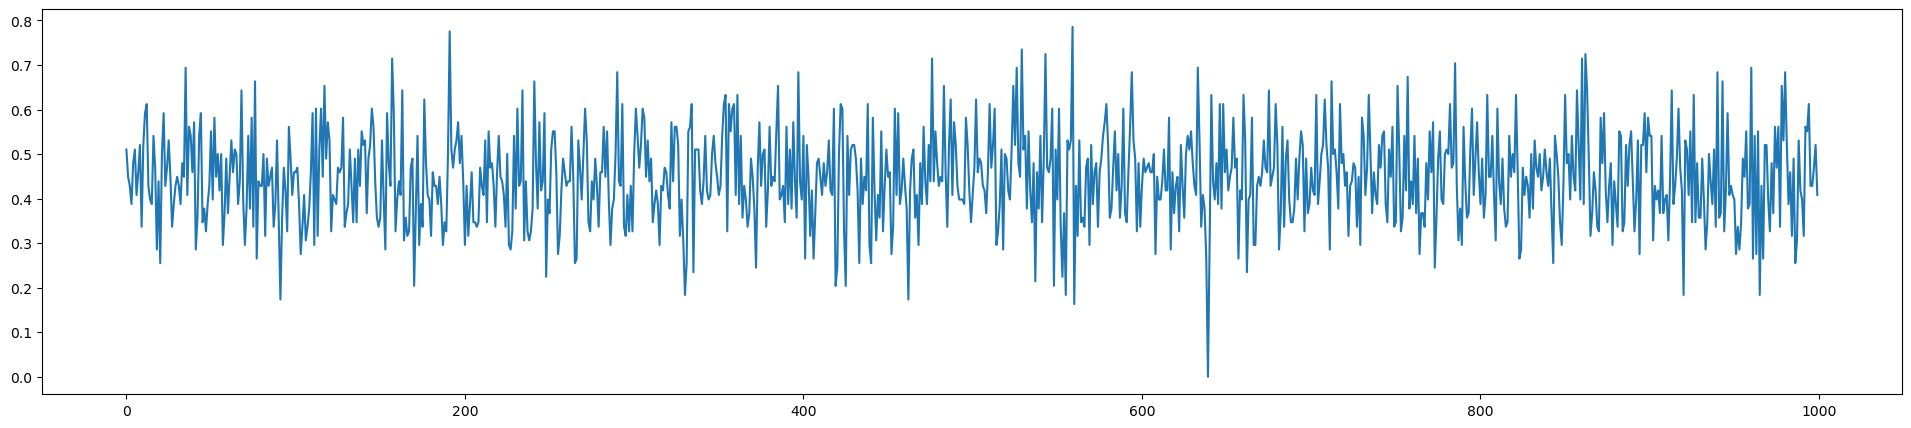

In [4]:
plt.figure(figsize=(24,5))
plt.plot(range(1000), inputs1[4,16000:17000])
plt.show()

In [5]:
from scipy import signal

# Apply a low-pass filter on with scipy.signal.filtfilt
def low_pass_filter(data, cutoff, fs, order=5):
    b, a = signal.butter(order, cutoff, btype='low', analog=False, fs=fs)
    return signal.filtfilt(b, a, data)

def high_pass_filter(data, cutoff, fs, order=5):
    b, a = signal.butter(order, cutoff, btype='high', analog=False, fs=fs)
    return signal.filtfilt(b, a, data)

def band_pass_filter(data, lowcut, highcut, fs, order=5):
    b, a = signal.butter(3, [lowcut, highcut], btype='band', fs=fs)
    return signal.filtfilt(b, a, data)


# Algorithm
https://www.nature.com/articles/s41598-018-22077-3#Fig1

$ \Delta z_i =  \frac {1}{\beta}(target\_r - r_i) $

In [6]:
# helper function
def count_incoming_connexions(W):
    incoming_connexion = W.nonzero()[0]
    incoming_connexion_count = np.zeros(W.shape[0])
    for i in incoming_connexion:
        incoming_connexion_count[i] +=1
    return incoming_connexion_count

## Matrice initialization

https://www.nature.com/articles/s41598-018-22077-3
Based initialy on : 

    https://www.nature.com/articles/s41598-018-22077-3/tables/1
    N = 125 (12500 in the paper)
    Ratio of ne% = 0.8 -> ne = 100; ni% = 0.2  -> ni=25
    
    W_ei : Incoming excitatory connections per inhibitory neuron :10, with synaptic weight = 0.1mV
    W_ie : Incoming inhibitory connections per neuron :2,5, with synamtic weight : -0.8mV

In [7]:
from reservoir.reservoir import init_matrices

# Parameters
n_e = 100 # number of neurons for excitatory pool
n_i = 0 # number of neurons for inhibitory pool
SEED = 65718 # previous 3789
leaky_rate = 1

spectral_radius = 1
input_connectivity = 1
connectivity = 0.1 # from the article

# HYPERPARAMETERS
INCREMENT = 100
VALUE = 0.1
bias_scaling = 1
input_scaling = 0.1


# Initialisation EE
Win_e, W_ee, bias_e =  init_matrices(n_e, input_connectivity, connectivity, spectral_radius, seed=SEED)
bias_e = bias_e*bias_scaling
Win_e = Win_e*input_scaling

# last_state
last_state_e = np.random.uniform(0, 1, n_e)


<AxesSubplot: >

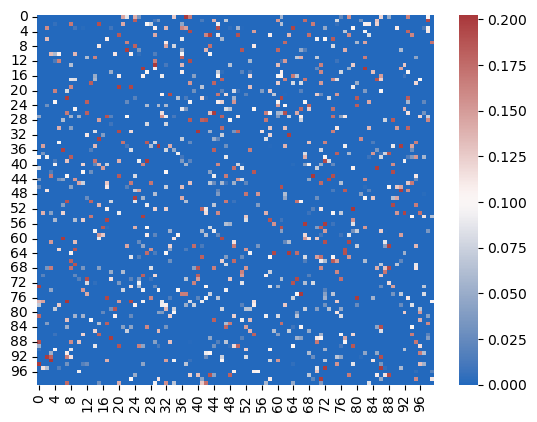

In [10]:
heatmap(W_ee.todense(), cmap=color_palette("vlag", as_cmap=True))

## Parameters grid exploration

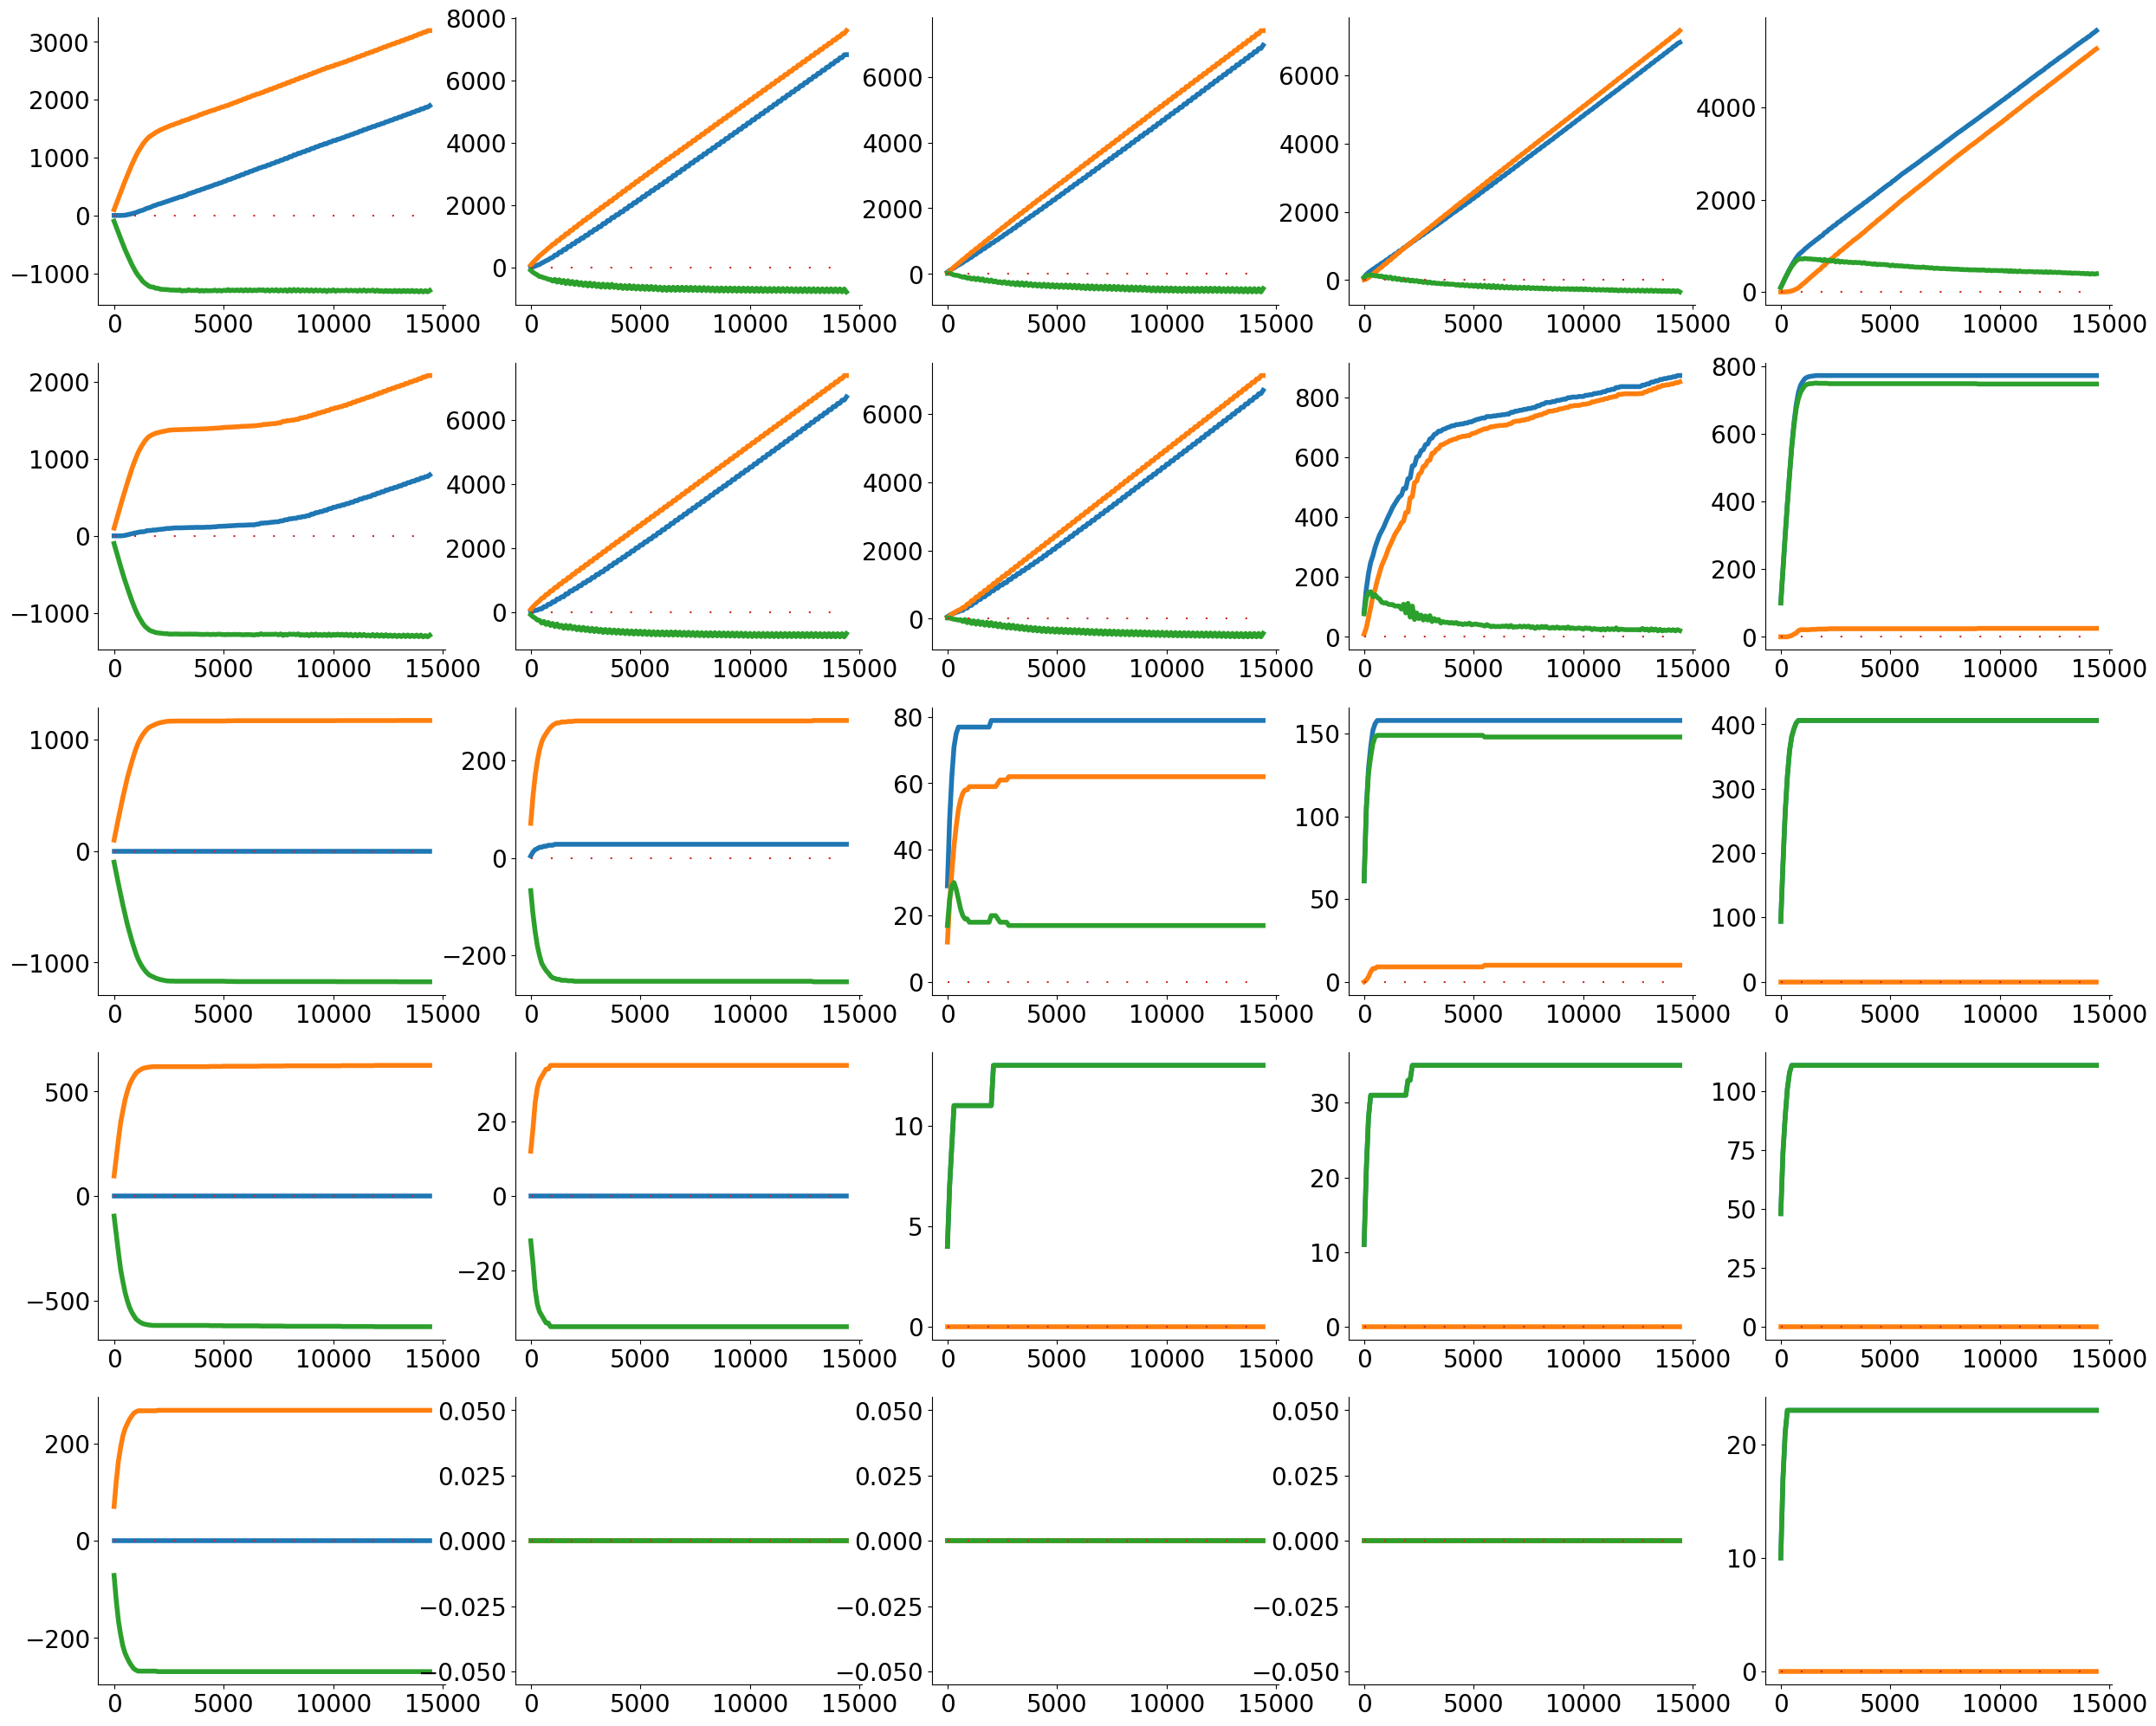

In [11]:
%matplotlib inline
import connexion_generation.bounded_adsp
from connexion_generation.bounded_adsp import bounded_adsp
reload(connexion_generation.bounded_adsp)
import connexion_generation.utility
from connexion_generation.utility import compute_synaptic_change
reload(connexion_generation.utility)

GROWTH_PARAMETER_ARRAY = [0.001, 0.01, 0.1, 0.3, 0.5]
TARGET_RATE_ARRAY = [0.1, 0.5, 0.7, 0.8, 0.95]
# GROWTH_PARAMETER_ARRAY = [0.5, 0.1]
# TARGET_RATE_ARRAY = [0.5, 0.7]

# The parameters you want to see the influence
fig, ax = plt.subplots(len(GROWTH_PARAMETER_ARRAY), len(TARGET_RATE_ARRAY), figsize=(30, 25))


k = 0
for growth_parameter in GROWTH_PARAMETER_ARRAY:
    j = 0
    for target_rate in TARGET_RATE_ARRAY:
        # Initialisation
        W_ee_adsp = W_ee.copy()
        u_train_adsp1 = inputs1.copy()
        state_e = last_state_e
        Win_adsp = Win_e

        step = 0

        total_add = 0
        total_prun = 0
        add = []
        prun = []

        state_history_e = []
        
        for i in range(INCREMENT * 5):
            state_e = update_reservoir(W_ee_adsp, Win_adsp, u_train_adsp1[:,i], state_e, leaky_rate, bias_e, activation_function)
            state_history_e.append(state_e)
        u_train_adsp1 = u_train_adsp1[:, INCREMENT * 5:]
        train_length = len(u_train_adsp1[1, :])

        while train_length > 5000:
            # For excitatory neurons (We and Wie)
            delta_z = compute_synaptic_change(state_history_e[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
            W_ee_adsp, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_adsp, state_e, delta_z, VALUE)

            # For inhibitory neurons (Wi)
            # delta_z_i = compute_synaptic_change(state_history_i[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
            # W_ei_adsp, _, nb_new_add_i, nb_new_prun_i = bounded_adsp(W_ei_adsp, state_i, delta_z_i, VALUE)

            for i in range(INCREMENT):
                state_e = update_reservoir(W_ee_adsp, Win_adsp, u_train_adsp1[:,i], state_e, leaky_rate, bias_e, activation_function)
                state_history_e.append(state_e)
            u_train_adsp1 = u_train_adsp1[:, INCREMENT:]
            train_length = len(u_train_adsp1[1, :])

            total_add += nb_new_add_e  # + nb_new_add_i
            total_prun += nb_new_prun_e # + nb_new_prun_i
            add.append(total_add)
            prun.append(total_prun)

            step += 1
            

        add = np.array(add)
        prun = np.array(prun)
        ax[k][j].plot(np.arange(step) * INCREMENT, add, linewidth=4, label="total number of added connexion")
        ax[k][j].plot(np.arange(step) * INCREMENT, prun, linewidth=4, label="total number of prunned connexion")
        ax[k][j].plot(np.arange(step) * INCREMENT, add - prun, linewidth=4, label="difference")
        ax[k][j].plot(np.arange(step) * INCREMENT, [0] * step, linestyle=(0, (1, 10)))
        # ax[k][j].set_title(f'\u03B2 :{growth_parameter}     \u03C1 :{target_rate}', fontsize= 20, fontweight= 'bold')
        ax[k][j].tick_params(axis='both', labelsize=20)
        ax[k][j].spines['top'].set_visible(False)
        ax[k][j].spines['right'].set_visible(False)
        j += 1
    k += 1


## for sepctral radius

In [13]:

GROWTH_PARAMETER_ARRAY = [0.001, 0.01, 0.1, 0.3, 0.5]
TARGET_RATE_ARRAY = [0.1, 0.5, 0.7, 0.8, 0.95]
# GROWTH_PARAMETER_ARRAY = [0.5, 0.1]
# TARGET_RATE_ARRAY = [0.5, 0.7]

# The parameters you want to see the influence

spr = np.zeros((len(GROWTH_PARAMETER_ARRAY), len(TARGET_RATE_ARRAY), 10))


for l in range(10):
    k = 0
    
    # Initialisation EE
    Win_e, W_ee, bias_e =  init_matrices(n_e, input_connectivity, connectivity, spectral_radius)
    bias_e = bias_e*bias_scaling
    Win_e = Win_e*input_scaling

    # last_state
    last_state_e = np.random.uniform(0, 1, n_e)
    last_state_i = np.random.uniform(0, 1, n_i)
    for growth_parameter in GROWTH_PARAMETER_ARRAY:
        j = 0
        for target_rate in TARGET_RATE_ARRAY:
            # Initialisation
            W_ee_adsp = W_ee.copy()
            u_train_adsp1 = inputs1.copy()
            state_e = last_state_e
            Win_adsp = Win_e

            step = 0

            state_history_e = []

            for i in range(INCREMENT * 5):
                state_e = update_reservoir(W_ee_adsp, Win_adsp, u_train_adsp1[:,i], state_e, leaky_rate, bias_e, activation_function)
                state_history_e.append(state_e)
            u_train_adsp1 = u_train_adsp1[:, INCREMENT * 5:]
            train_length = len(u_train_adsp1[1, :])

            while train_length > 5000:
                # For excitatory neurons (We and Wie)
                delta_z = compute_synaptic_change(state_history_e[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
                W_ee_adsp, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_adsp, state_e, delta_z, VALUE)


                for i in range(INCREMENT):
                    state_e = update_reservoir(W_ee_adsp, Win_adsp, u_train_adsp1[:,i], state_e, leaky_rate, bias_e, activation_function)
                    state_history_e.append(state_e)
                u_train_adsp1 = u_train_adsp1[:, INCREMENT:]
                train_length = len(u_train_adsp1[1, :])

                step += 1

            eigen = sparse.linalg.eigs(W_ee_adsp, k=1, which="LM", maxiter=W_ee_adsp.shape[0] * 20, tol=0.1, return_eigenvectors=False)
            sr  = max(abs(eigen))
            spr[k][j][l] = sr

            j += 1
        k += 1


In [14]:
spr

array([[[ 0.78843067,  0.6698407 ,  0.75799824,  0.67742954,
          0.78230011,  0.68298438,  0.78420158,  0.73332515,
          0.66666979,  0.65263756],
        [ 0.78701565,  0.90392167,  0.782479  ,  0.89760494,
          0.89954879,  0.78298684,  0.87764832,  0.89225163,
          0.88239398,  0.88730867],
        [ 1.11849234,  1.10560401,  1.0165449 ,  1.01468104,
          0.99860967,  1.10738701,  1.11580557,  1.10574073,
          1.10215416,  1.01168093],
        [ 1.24350756,  1.1934699 ,  1.24162776,  1.23626737,
          1.20131929,  1.23049682,  1.22149611,  1.21232568,
          1.18991039,  1.21411199],
        [ 1.80789109,  1.80291851,  1.79479366,  1.79306752,
          1.78834972,  1.80128425,  1.77656201,  1.78392697,
          1.78183294,  1.79408826]],

       [[ 0.84890212,  0.8979556 ,  0.84973135,  0.87126323,
          0.82847502,  0.86384406,  0.93913923,  0.98848173,
          0.87987075,  0.85137145],
        [ 0.886454  ,  0.90230386,  0.89088968,  0

In [15]:
mean_spr = np.mean(spr, axis=2)
std_spr = np.std(spr, axis=2)
mean_spr

array([[0.71958177, 0.85931595, 1.06967004, 1.21845329, 1.79247149],
       [0.88190345, 0.87328492, 1.0703873 , 1.22257655, 1.80124192],
       [2.07996922, 0.87526283, 1.07395252, 1.19699494, 1.45786183],
       [0.61684321, 0.97698436, 1.0208883 , 1.05394366, 1.15158426],
       [0.8343803 , 1.        , 1.00042681, 1.00530907, 1.03419361]])

In [16]:
std_spr

array([[5.23313917e-02, 4.97682672e-02, 4.88268593e-02, 1.85074426e-02,
        9.42984001e-03],
       [4.60944212e-02, 4.03728057e-02, 4.85078304e-02, 2.33033885e-02,
        2.72802848e-03],
       [3.87733255e+00, 3.54582739e-03, 2.60252977e-03, 3.68395446e-03,
        2.01781207e-03],
       [5.45707031e-03, 1.23071612e-03, 1.07713268e-03, 3.53097852e-03,
        2.57127976e-03],
       [1.76930108e-03, 2.76152401e-09, 8.68475164e-09, 3.38654705e-04,
        2.02654964e-03]])

/home/idlab278/Code/structural_plasticity/adsp/reservoir/reservoir.py:229: RuntimeWarning: divide by zero encountered in double_scalars
  W *= spectral_radius / sr


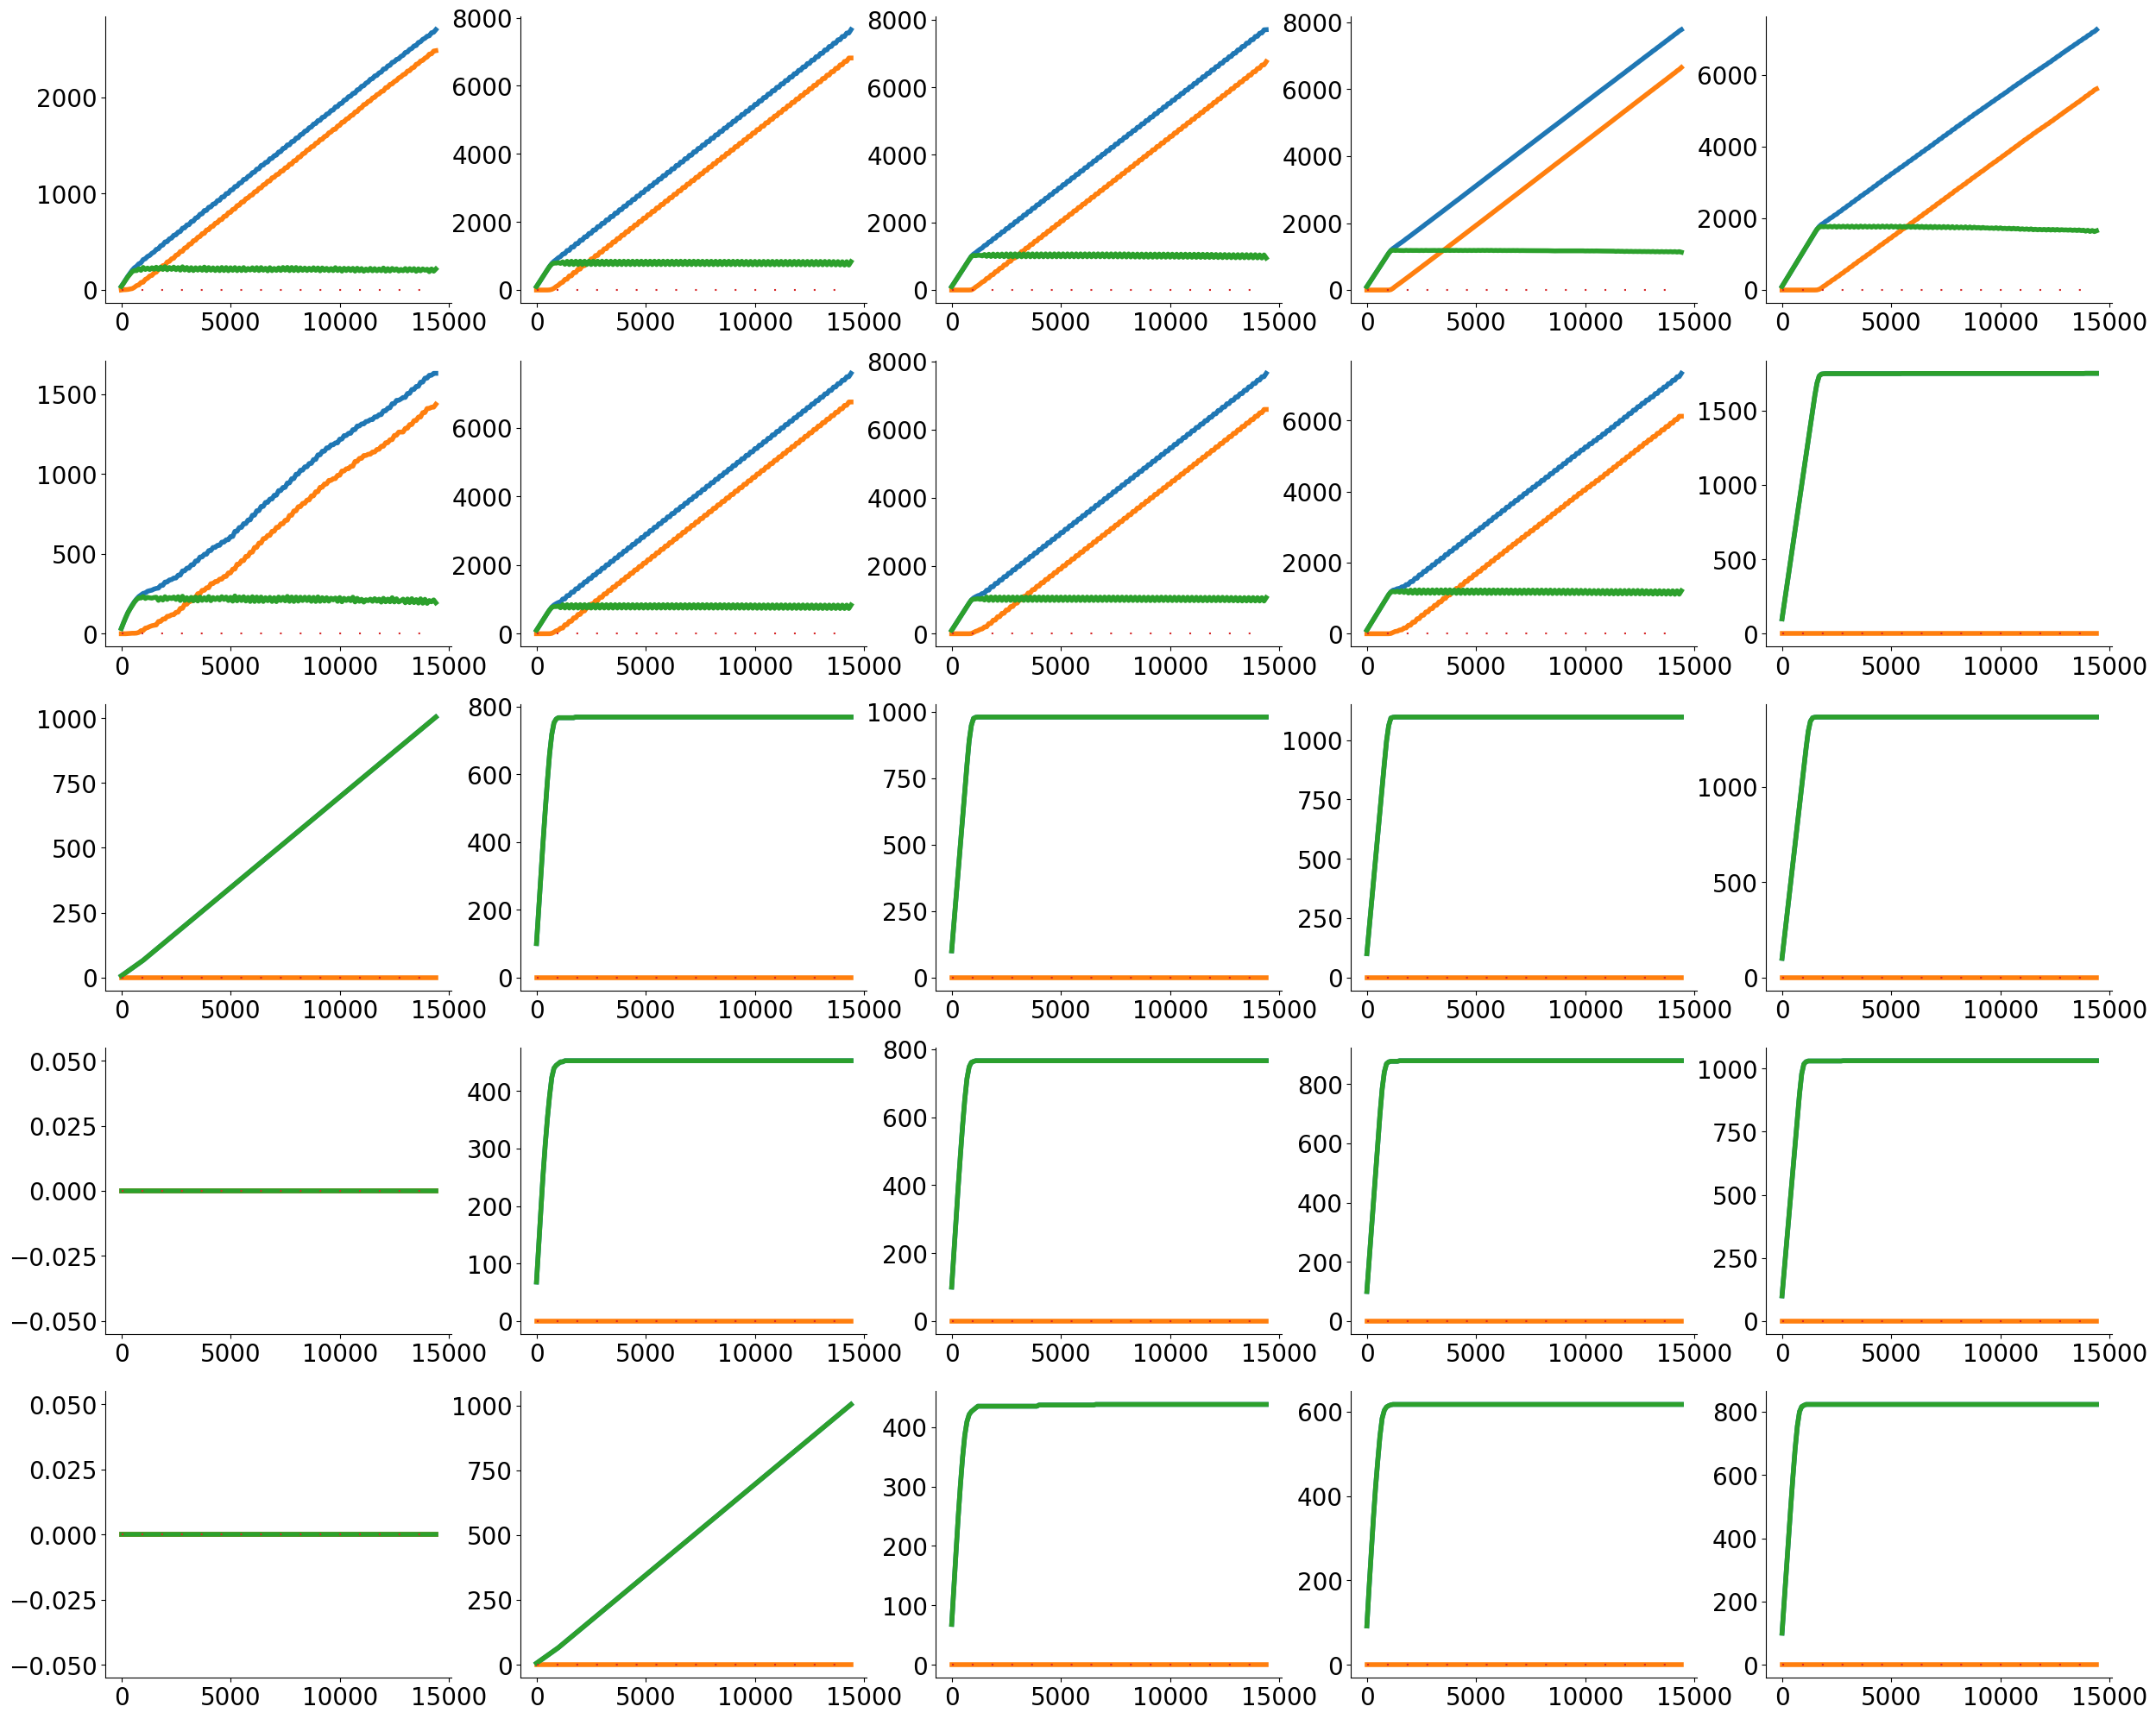

In [17]:
%matplotlib inline
import connexion_generation.bounded_adsp
from connexion_generation.bounded_adsp import bounded_adsp
reload(connexion_generation.bounded_adsp)
import connexion_generation.utility
from connexion_generation.utility import compute_synaptic_change
reload(connexion_generation.utility)

GROWTH_PARAMETER_ARRAY = [0.001, 0.01, 0.1, 0.3, 0.5]
TARGET_RATE_ARRAY = [0.1, 0.5, 0.7, 0.8, 0.95]


# Initialisation EE
Win_e, W_ee, bias_e =  init_matrices(n_e, input_connectivity, 0, spectral_radius, seed=SEED)
bias_e = bias_e*bias_scaling
Win_e = Win_e*input_scaling

# last_state
last_state_e = np.random.uniform(0, 1, n_e)

# The parameters you want to see the influence
fig, ax = plt.subplots(len(GROWTH_PARAMETER_ARRAY), len(TARGET_RATE_ARRAY), figsize=(30, 25))


k = 0
for growth_parameter in GROWTH_PARAMETER_ARRAY:
    j = 0
    for target_rate in TARGET_RATE_ARRAY:
        # Initialisation
        W_ee_adsp = W_ee.copy()
        u_train_adsp1 = inputs1.copy()
        state_e = last_state_e
        Win_adsp = Win_e

        step = 0

        total_add = 0
        total_prun = 0
        add = []
        prun = []

        state_history_e = []
        
        for i in range(INCREMENT * 5):
            state_e = update_reservoir(W_ee_adsp, Win_adsp, u_train_adsp1[:,i], state_e, leaky_rate, bias_e, activation_function)
            state_history_e.append(state_e)
        u_train_adsp1 = u_train_adsp1[:, INCREMENT * 5:]
        train_length = len(u_train_adsp1[1, :])

        while train_length > 5000:
            # For excitatory neurons (We and Wie)
            delta_z = compute_synaptic_change(state_history_e[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
            W_ee_adsp, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_adsp, state_e, delta_z, VALUE)

            # For inhibitory neurons (Wi)
            # delta_z_i = compute_synaptic_change(state_history_i[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
            # W_ei_adsp, _, nb_new_add_i, nb_new_prun_i = bounded_adsp(W_ei_adsp, state_i, delta_z_i, VALUE)

            for i in range(INCREMENT):
                state_e = update_reservoir(W_ee_adsp, Win_adsp, u_train_adsp1[:,i], state_e, leaky_rate, bias_e, activation_function)
                state_history_e.append(state_e)
            u_train_adsp1 = u_train_adsp1[:, INCREMENT:]
            train_length = len(u_train_adsp1[1, :])

            total_add += nb_new_add_e  # + nb_new_add_i
            total_prun += nb_new_prun_e # + nb_new_prun_i
            add.append(total_add)
            prun.append(total_prun)

            step += 1
            

        add = np.array(add)
        prun = np.array(prun)
        ax[k][j].plot(np.arange(step) * INCREMENT, add, linewidth=4, label="total number of added connexion")
        ax[k][j].plot(np.arange(step) * INCREMENT, prun, linewidth=4, label="total number of prunned connexion")
        ax[k][j].plot(np.arange(step) * INCREMENT, add - prun, linewidth=4, label="difference")
        ax[k][j].plot(np.arange(step) * INCREMENT, [0] * step, linestyle=(0, (1, 10)))
        # ax[k][j].set_title(f'\u03B2 :{growth_parameter}     \u03C1 :{target_rate}', fontsize= 20, fontweight= 'bold')
        ax[k][j].tick_params(axis='both', labelsize=20)
        ax[k][j].spines['top'].set_visible(False)
        ax[k][j].spines['right'].set_visible(False)
        j += 1
    k += 1


In [18]:

GROWTH_PARAMETER_ARRAY = [0.001, 0.01, 0.1, 0.3, 0.5]
TARGET_RATE_ARRAY = [0.1, 0.5, 0.7, 0.8, 0.95]
# GROWTH_PARAMETER_ARRAY = [0.5, 0.1]
# TARGET_RATE_ARRAY = [0.5, 0.7]

# The parameters you want to see the influence

spr = np.zeros((len(GROWTH_PARAMETER_ARRAY), len(TARGET_RATE_ARRAY), 10))


for l in range(10):
    k = 0
    
    # Initialisation EE
    Win_e, W_ee, bias_e =  init_matrices(n_e, input_connectivity, 0, spectral_radius)
    bias_e = bias_e*bias_scaling
    Win_e = Win_e*input_scaling

    # last_state
    last_state_e = np.random.uniform(0, 1, n_e)
    for growth_parameter in GROWTH_PARAMETER_ARRAY:
        j = 0
        for target_rate in TARGET_RATE_ARRAY:
            # Initialisation
            W_ee_adsp = W_ee.copy()
            u_train_adsp1 = inputs1.copy()
            state_e = last_state_e
            Win_adsp = Win_e

            step = 0

            state_history_e = []

            for i in range(INCREMENT * 5):
                state_e = update_reservoir(W_ee_adsp, Win_adsp, u_train_adsp1[:,i], state_e, leaky_rate, bias_e, activation_function)
                state_history_e.append(state_e)
            u_train_adsp1 = u_train_adsp1[:, INCREMENT * 5:]
            train_length = len(u_train_adsp1[1, :])

            while train_length > 5000:
                # For excitatory neurons (We and Wie)
                delta_z = compute_synaptic_change(state_history_e[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
                W_ee_adsp, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_adsp, state_e, delta_z, VALUE)


                for i in range(INCREMENT):
                    state_e = update_reservoir(W_ee_adsp, Win_adsp, u_train_adsp1[:,i], state_e, leaky_rate, bias_e, activation_function)
                    state_history_e.append(state_e)
                u_train_adsp1 = u_train_adsp1[:, INCREMENT:]
                train_length = len(u_train_adsp1[1, :])

                step += 1

            eigen = sparse.linalg.eigs(W_ee_adsp, k=1, which="LM", maxiter=W_ee_adsp.shape[0] * 20, tol=0.1, return_eigenvectors=False)
            sr  = max(abs(eigen))
            spr[k][j][l] = sr

            j += 1
        k += 1


In [19]:
mean_spr = np.mean(spr, axis=2)
std_spr = np.std(spr, axis=2)
mean_spr

array([[ 0.68748862,  0.84658396,  1.0694276 ,  1.20429636,  1.76862927],
       [ 0.86492564,  0.81811296,  1.07240304,  1.18823433,  1.75108356],
       [13.78492854,  0.8104027 ,  0.98639263,  1.1003158 ,  1.3673839 ],
       [ 0.        ,  0.79543237,  0.81463269,  0.89438769,  1.03602631],
       [ 0.        , 13.78023503,  0.78079006,  0.76706726,  0.84694307]])

In [20]:
std_spr

array([[0.06076568, 0.01016545, 0.01594385, 0.01355995, 0.01002548],
       [0.07114951, 0.04805558, 0.00564579, 0.05036712, 0.00167624],
       [0.022956  , 0.00589535, 0.00696633, 0.00574248, 0.00173861],
       [0.        , 0.02310694, 0.00822659, 0.00491216, 0.00493265],
       [0.        , 0.03491991, 0.01886083, 0.01400512, 0.01276071]])

## Simulation

Excitatory neuron evolution is given by : 

$ r_E^{t+1} = W_{EE}r_E^{t} - W_{IE}r_I^{t} + W_{in}u^{t} + bias_E $

Inhibitory neurons evolution is given by : 

$ r_I^{t+1} = W_{EI}r_E^{t} + bias_I $


In [21]:
from reservoir.reservoir import init_matrices

# Parameters
n_e = 100 # number of neurons for excitatory pool
n_i = 0 # number of neurons for inhibitory pool
SEED = 65718 # previous 3789
leaky_rate = 1

spectral_radius = 1
input_connectivity =  1
connectivity_e = 0 # from the article
connectivity = 0 # from the article

# HYPERPARAMETERS
INCREMENT = 100
VALUE = 0.05
bias_scaling = 1
input_scaling = 1


# Initialisation EE
Win_e, W_ee, bias_e =  init_matrices(n_e, input_connectivity, connectivity_e, spectral_radius, seed=SEED)
bias_e = bias_e*bias_scaling
Win_e = Win_e*input_scaling

# Initialisation EI
_, W_ei, _ =  init_matrices((n_i, n_e), 0, connectivity, 1, seed=SEED)

# Initialisation IE
_, W_ie, _ =  init_matrices((n_e, n_i), 0, connectivity, 1, seed=SEED)

# Initialisation II
_, _, bias_i =  init_matrices(n_i, 0, connectivity, 1, seed=SEED)
bias_i = bias_i*bias_scaling

# last_state
last_state_e = np.random.uniform(0, 1, n_e)
last_state_i = np.random.uniform(0, 1, n_i)

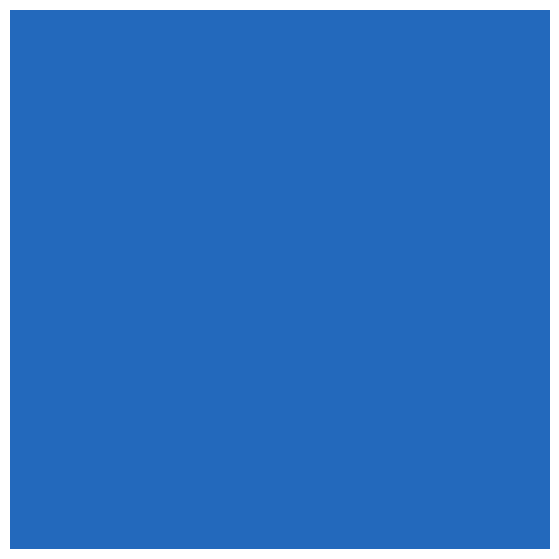

In [22]:
show_ei_matrix(W_ee, W_ei, W_ie)

In [23]:
import connexion_generation.bounded_adsp
from connexion_generation.bounded_adsp import bounded_adsp
reload(connexion_generation.bounded_adsp)
import connexion_generation.utility
from connexion_generation.utility import compute_synaptic_change
reload(connexion_generation.utility)

# Parameters
# The parameters you want to see the influence
growth_parameter = 0.1
target_rate=0.7

INCREMENT = 100
VALUE = 0.05

# Initialisation
W_ee_adsp = W_ee.copy()
u_train1 = inputs1.copy()
state_e = last_state_e
Win_e_adsp = Win_e

step=0

total_add = 0
total_prun = 0
add = []
prun = []
mean_prun = []

incoming_connexion_count_history = []
state_history_e = []
delta_z_e_history = []

for i in range(INCREMENT*5):
    state_e = update_reservoir(W_ee_adsp, Win_e_adsp, u_train1[:, i], state_e, leaky_rate, bias_e, activation_function)
    state_history_e.append(state_e)
u_train1 = u_train1[:, INCREMENT * 5:]

In [24]:
train_length = len(u_train1[1, :])

while train_length > 10000:

    incoming_connexion_count_history.append(count_incoming_connexions(W_ee_adsp))

     # For excitatory neurons (We and Wie)
    delta_z_e = compute_synaptic_change(state_history_e[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
    W_ee_adsp, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_adsp, state_e, delta_z_e, VALUE)
    delta_z_e_history.append(delta_z_e)
    
    # For inhibitory neurons (Wei)
    # delta_z_i = compute_synaptic_change(state_history_i[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
    # W_ei_adsp, _, nb_new_add_i, nb_new_prun_i = adsp(W_ei_adsp, state_i, delta_z_i, VALUE)

    for i in range(INCREMENT):
        state_e = update_reservoir(W_ee_adsp, Win_e_adsp, u_train1[:, i], state_e, leaky_rate, bias_e, activation_function)
        state_history_e.append(state_e)
    u_train1 = u_train1[:, INCREMENT:]
    train_length = len(u_train1[1, :])


    total_add += nb_new_add_e # + nb_new_add_i
    total_prun += nb_new_prun_e # + nb_new_prun_i
    add.append(total_add)
    prun.append(total_prun)
    step +=1
add = np.array(add)
prun = np.array(prun)

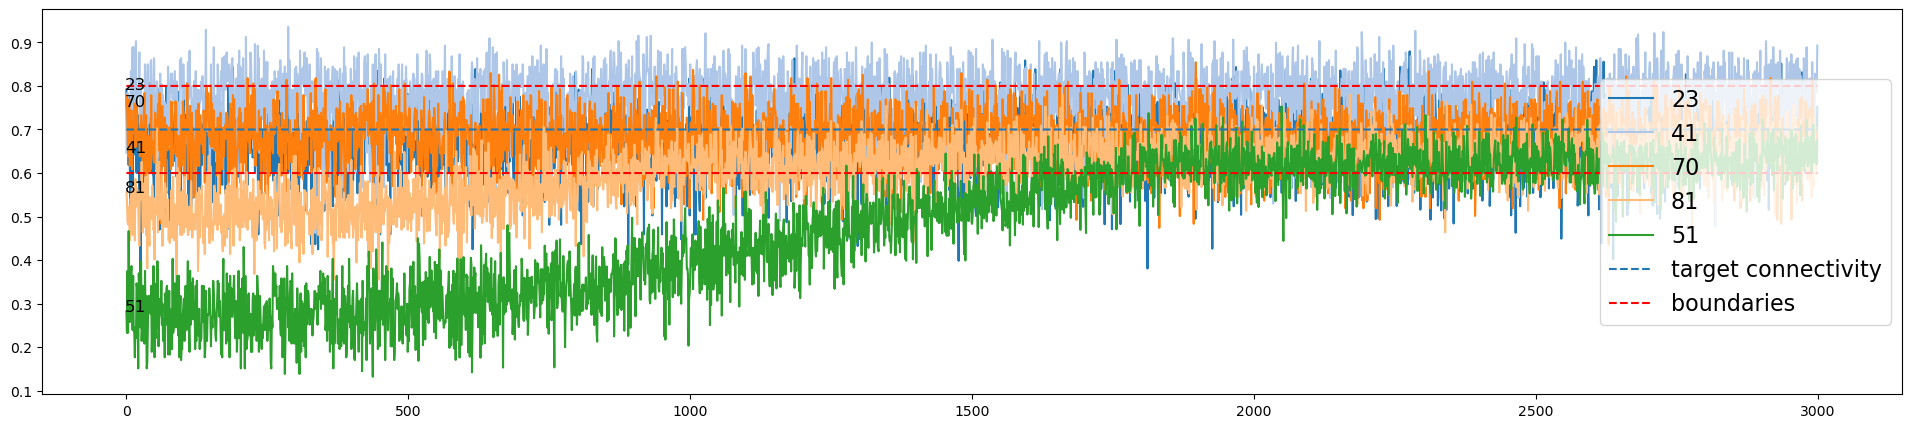

In [25]:
# NEURON ACTIVITY PLOT 
plt.figure(figsize=(24,5))
random_neurons_indices =  np.sort(np.random.randint(n_e, size=4)) #Size max is 19 because there is not enough colors
random_neurons_indices = np.append(random_neurons_indices, 51)
colors = color_palette("tab20")
# NUMBER_OF_STEP_TO_WATCH 
WATCH_FROM = 0
WATCH_TO = 3000
neurons_evolution = np.array(state_history_e)[WATCH_FROM:WATCH_TO]
x =range(len(state_history_e))[WATCH_FROM:WATCH_TO]
j = 0
for i in random_neurons_indices:
    plt.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    plt.text(-3+WATCH_FROM, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1
plt.plot(x, [target_rate]*(WATCH_TO-WATCH_FROM), linestyle = "--", label="target connectivity")
plt.plot(x, [target_rate+growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--", label="boundaries")
plt.plot(x, [target_rate-growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--")
# to watch the inputs simultaneously
# ax0.plot(x, inputs1[0, WATCH_FROM:WATCH_TO], color="blue", linestyle = "--")

plt.legend(fontsize=16, loc="right")


## Analysis

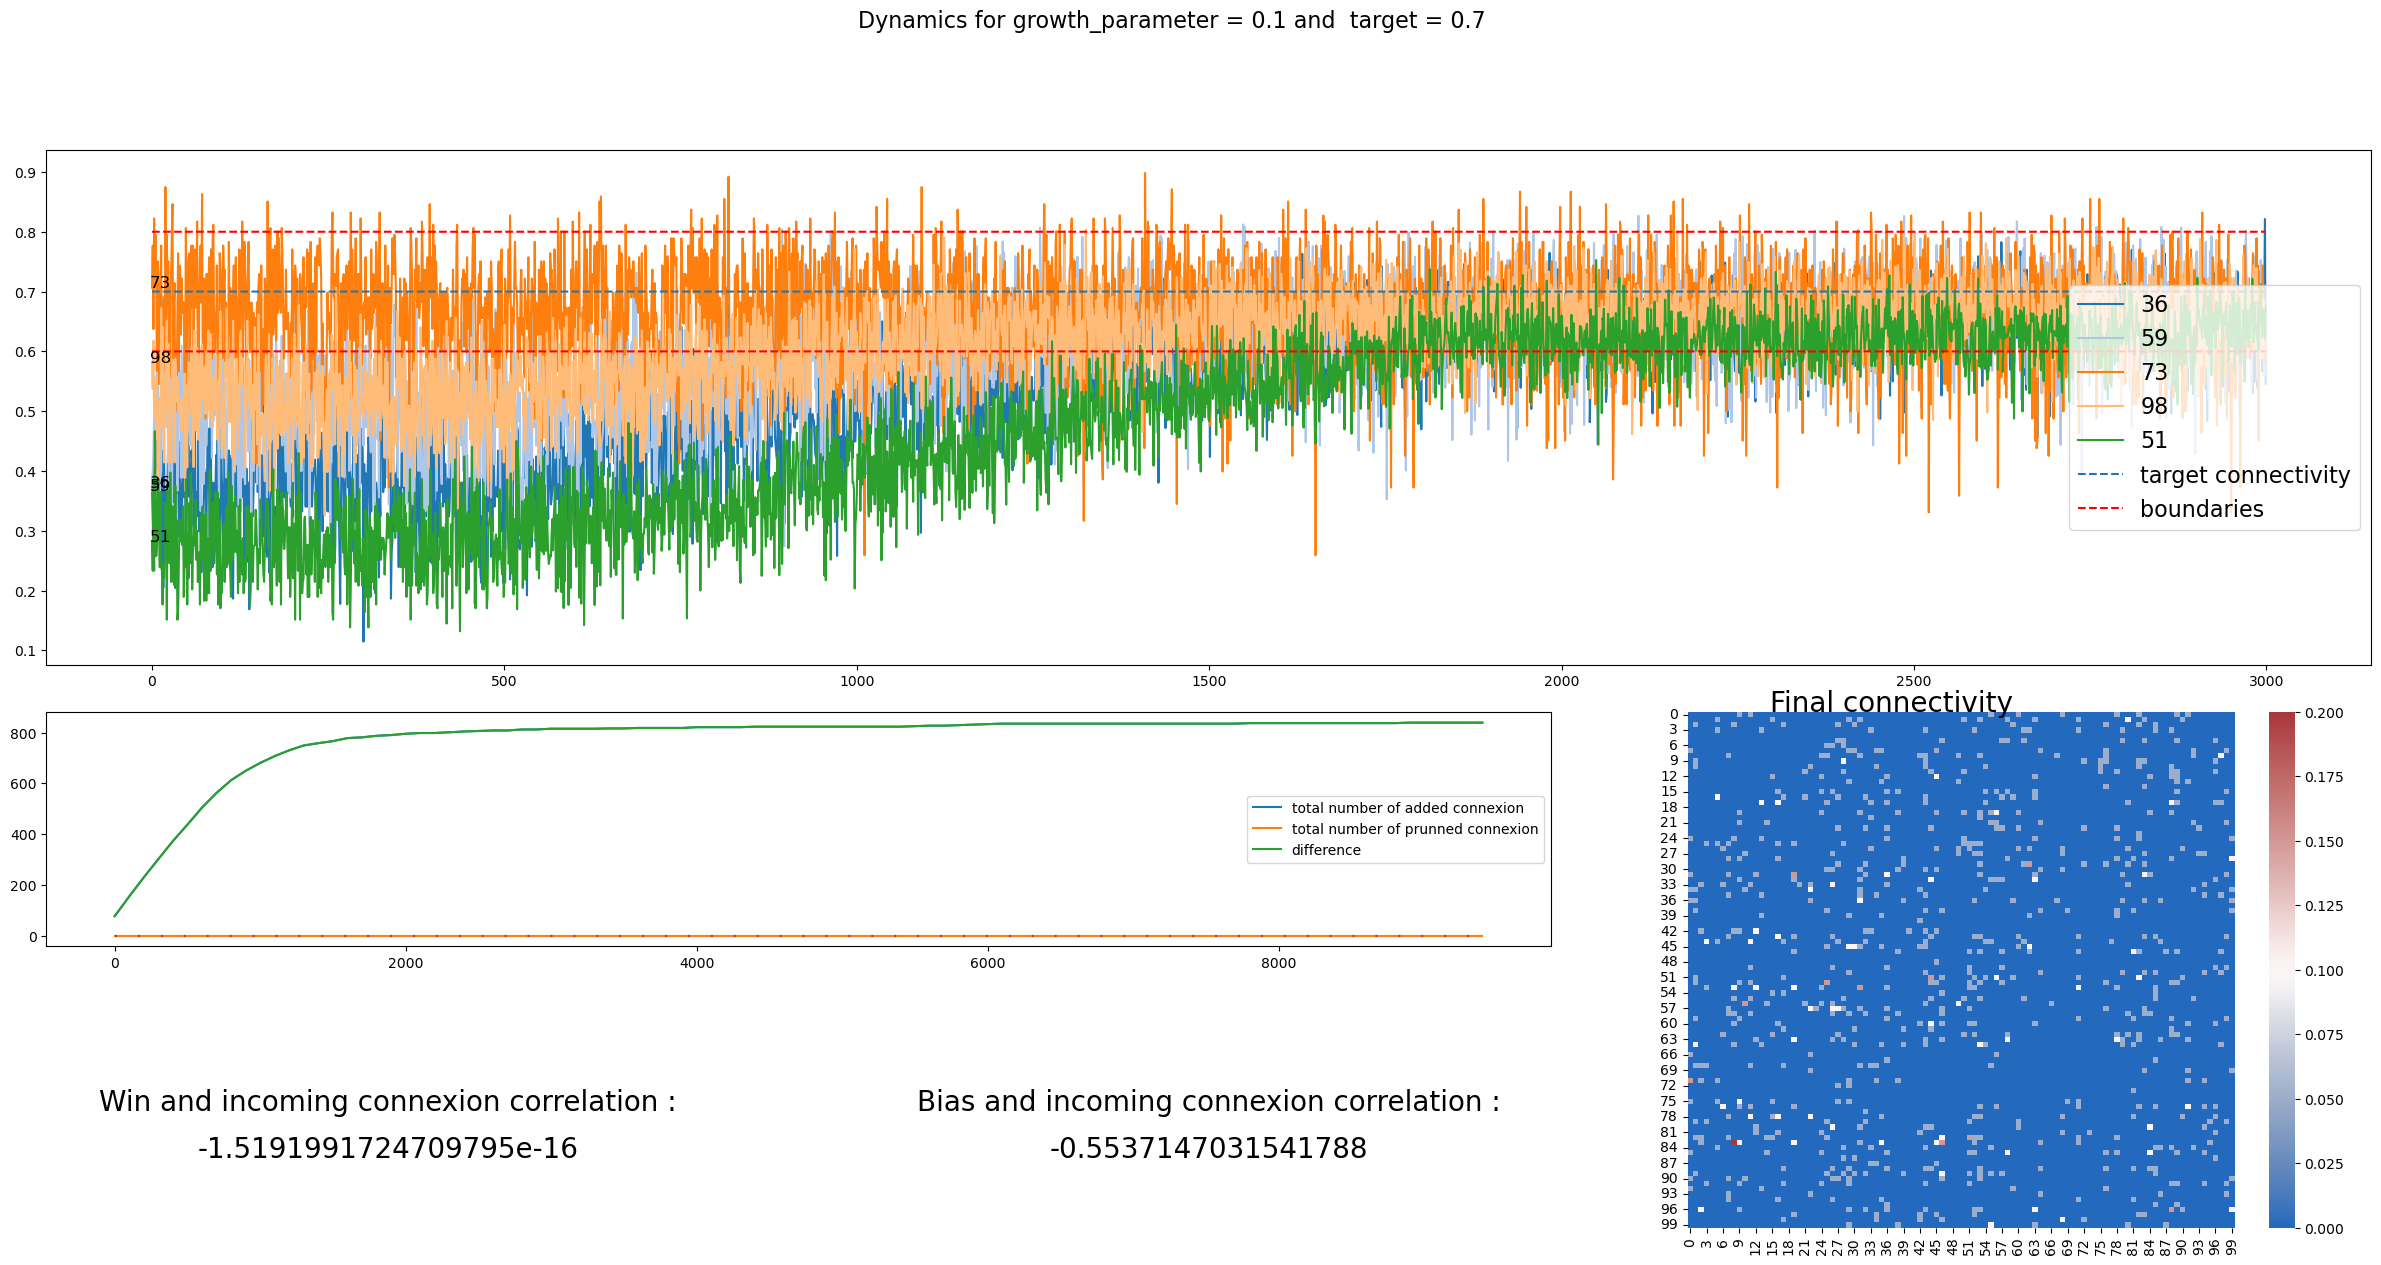

In [26]:
from math import copysign
from analysis.metrics import pearson 

plt.figure(figsize=(30,14))
plt.suptitle(f'Dynamics for growth_parameter = {growth_parameter} and  target = {target_rate}', fontsize=16)

# NEURON ACTIVITY PLOT 
ax0 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=2)
random_neurons_indices =  np.sort(np.random.randint(n_e, size=4)) #Size max is 19 because there is not enough colors
random_neurons_indices = np.append(random_neurons_indices, 51)
colors = color_palette("tab20")
# NUMBER_OF_STEP_TO_WATCH 
WATCH_FROM = 0
WATCH_TO = 3000
neurons_evolution = np.array(state_history_e)[WATCH_FROM:WATCH_TO]
x =range(len(state_history_e))[WATCH_FROM:WATCH_TO]
j = 0
for i in random_neurons_indices:
    ax0.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    ax0.text(-3+WATCH_FROM, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1
ax0.plot(x, [target_rate]*(WATCH_TO-WATCH_FROM), linestyle = "--", label="target connectivity")
ax0.plot(x, [target_rate+growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--", label="boundaries")
ax0.plot(x, [target_rate-growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--")
# to watch the inputs simultaneously
# ax0.plot(x, inputs1[0, WATCH_FROM:WATCH_TO], color="blue", linestyle = "--")

plt.legend(fontsize=16, loc="right")


# TOTAL ADDITION AND PRUNING OF CONNEXIONS 
ax1 = plt.subplot2grid((4, 3), (2, 0), colspan=2)
ax1.plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
ax1.plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
ax1.plot(np.arange(step)*INCREMENT, add-prun, label="difference")
ax1.plot(np.arange(step)*INCREMENT, [0]*step, linestyle=(0, (1, 10)))
ax1.legend()

# CONNEXION MATRICE
ax2 = plt.subplot2grid((4, 3), (2, 2), rowspan=2)
heatmap(W_ee_adsp.todense(), cmap=color_palette("vlag", as_cmap=True), ax = ax2)
ax2.text(15,0, 'Final connectivity',fontsize=20)

ax3 = plt.subplot2grid((4, 3), (3, 0))
ax3.text(0.5, 0.5, 'Win and incoming connexion correlation :',fontsize=20,horizontalalignment='center',
        transform=ax3.transAxes)
ax3.text(0.5, 0.3, pearson(Win_e.A, incoming_connexion_count_history[-1]),fontsize=20,horizontalalignment='center',
        transform=ax3.transAxes)
ax3.axis('off')

ax4 = plt.subplot2grid((4, 3), (3, 1))
ax4.text(0.5, 0.5, 'Bias and incoming connexion correlation :',fontsize=20,horizontalalignment='center',
        transform=ax4.transAxes)
ax4.text(0.5, 0.3, pearson(bias_e, incoming_connexion_count_history[-1]),fontsize=20,horizontalalignment='center',
        transform=ax4.transAxes)
ax4.axis('off')

plt.show()

<AxesSubplot: >

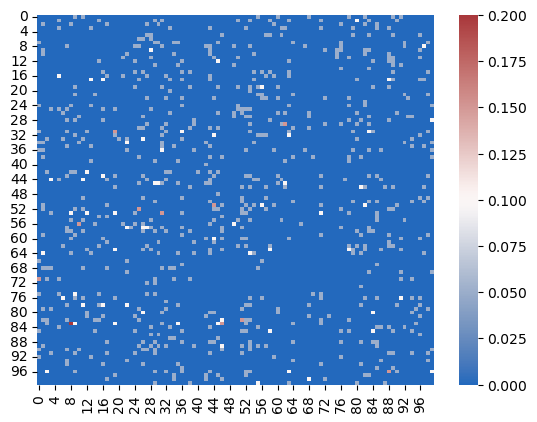

In [27]:
heatmap(W_ee_adsp.todense(), cmap=color_palette("vlag", as_cmap=True))

## Hebbian learning exemple

### Visualisation

<Figure size 2400x1000 with 0 Axes>

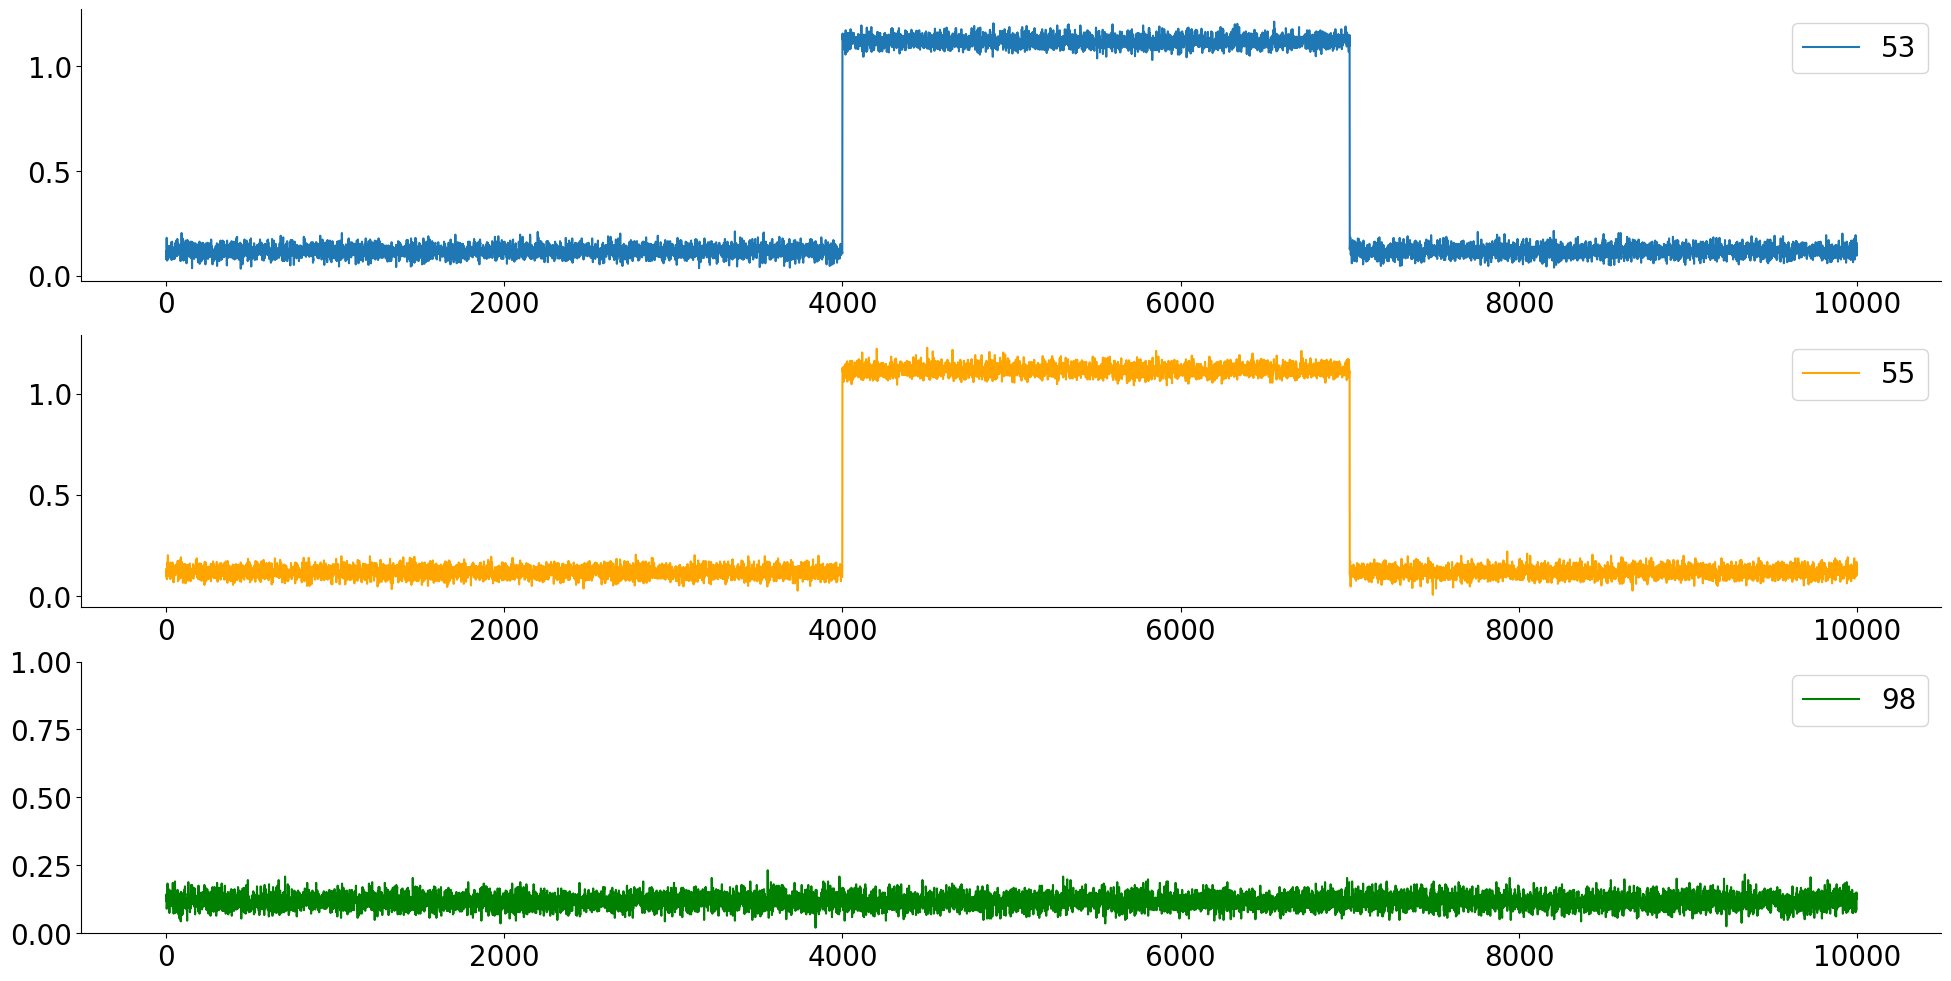

In [218]:
from scipy.stats import poisson

mu = 100
timesteps = 10000

U = poisson.rvs(mu, size=[timesteps, n_e], random_state = SEED)[np.newaxis].T

# rescale between 0 and 1
inputs_visu = (U - U.min()) / (U.max() - U.min())/4

inputs_visu[50:60,4000:7000] = inputs_visu[50:60,4000:7000]+1
plt.figure(figsize=(24,10))

ax = plt.subplots(3, 1,figsize=(24,12))
ax[1][0].plot(range(10000), inputs_visu[53,0:10000], label="53")
ax[1][0].legend(fontsize=26)
ax[1][1].plot(range(10000), inputs_visu[55,0:10000], label="55", color = "orange")
ax[1][1].legend(fontsize=26)
ax[1][2].plot(range(10000), inputs_visu[98,0:10000], label="98", color = "green")
ax[1][2].legend(fontsize=26)
ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][2].spines['top'].set_visible(False)
ax[1][2].spines['right'].set_visible(False)
ax[1][0].tick_params(axis='both', labelsize=26)
ax[1][1].tick_params(axis='both', labelsize=26)
ax[1][2].tick_params(axis='both', labelsize=26)

plt.ylim(0, 1)

plt.show()

### Scenario

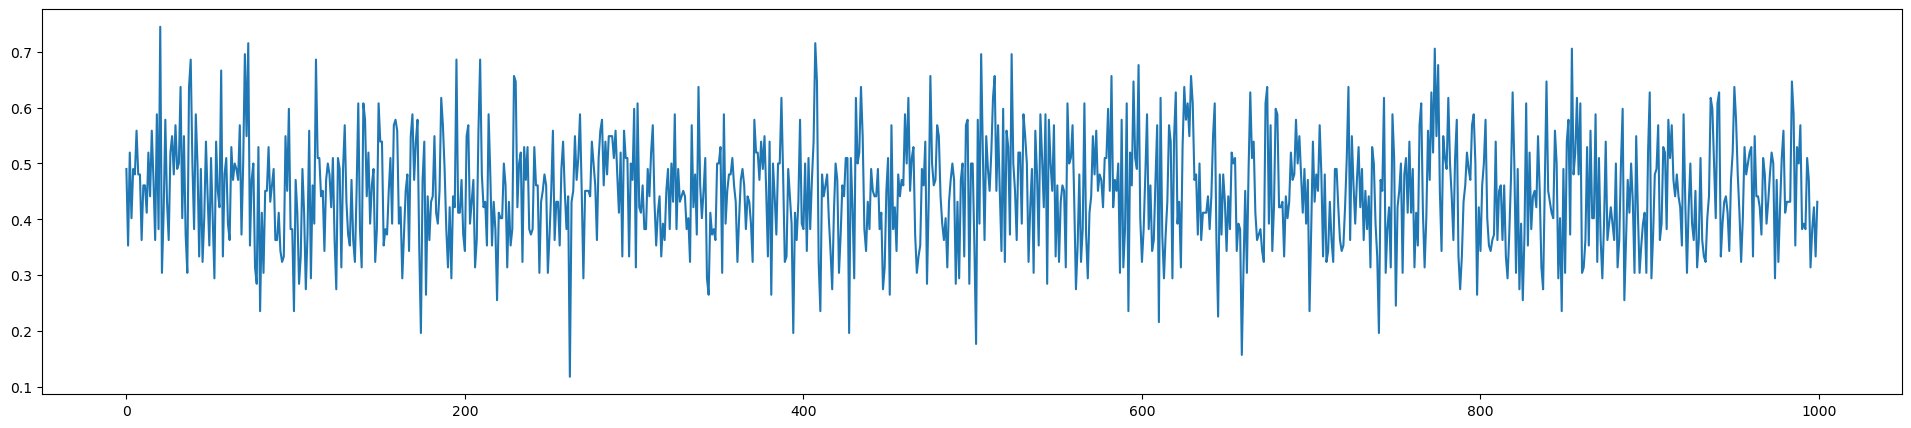

In [28]:
from scipy.stats import poisson

mu = 100
timesteps = 100000

U = poisson.rvs(mu, size=[timesteps, n_e], random_state = SEED)[np.newaxis].T

# rescale between 0 and 1
inputs2 = (U - U.min()) / (U.max() - U.min())

inputs2[50:60,:] = inputs2[50:60,:]*10
plt.figure(figsize=(24,5))
plt.plot(range(1000), inputs2[43,16000:17000])
plt.show()

In [29]:
u_train2 = inputs2.copy()

W_ee_adsp_hebbian = W_ee_adsp.copy()
Win_e_adsp_hebbian = Win_e

step=0
state_hebbian = state_e

total_add = 0
total_prun = 0
add = []
prun = []
mean_prun = []

state_history_hebbian = []
delta_z_e_history = []
train_length = len(u_train2[1, :])

In [30]:
while train_length > 500:
     # For excitatory neurons (We and Wie)
    delta_z_e = compute_synaptic_change(state_history_hebbian[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
    W_ee_adsp_hebbian, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_adsp_hebbian, state_hebbian, delta_z_e, VALUE)
    delta_z_e_history.append(delta_z_e)
    
    # For inhibitory neurons (Wei)
    # delta_z_i = compute_synaptic_change(state_history_i[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
    # W_ei_adsp, _, nb_new_add_i, nb_new_prun_i = adsp(W_ei_adsp, state_i, delta_z_i, VALUE)

    for i in range(INCREMENT):
        state_hebbian = update_reservoir(W_ee_adsp_hebbian, Win_e_adsp_hebbian, u_train2[:, i], state_hebbian, leaky_rate, bias_e, activation_function)
        state_history_hebbian.append(state_hebbian)
    u_train2 = u_train2[:, INCREMENT:]
    train_length = len(u_train2[1, :])


    total_add += nb_new_add_e # + nb_new_add_i
    total_prun += nb_new_prun_e # + nb_new_prun_i
    add.append(total_add)
    prun.append(total_prun)
    step +=1
add = np.array(add)
prun = np.array(prun)

/home/idlab278/Applications/miniconda3/envs/adsp/lib/python3.10/site-packages/numpy/ma/core.py:5246: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/home/idlab278/Applications/miniconda3/envs/adsp/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


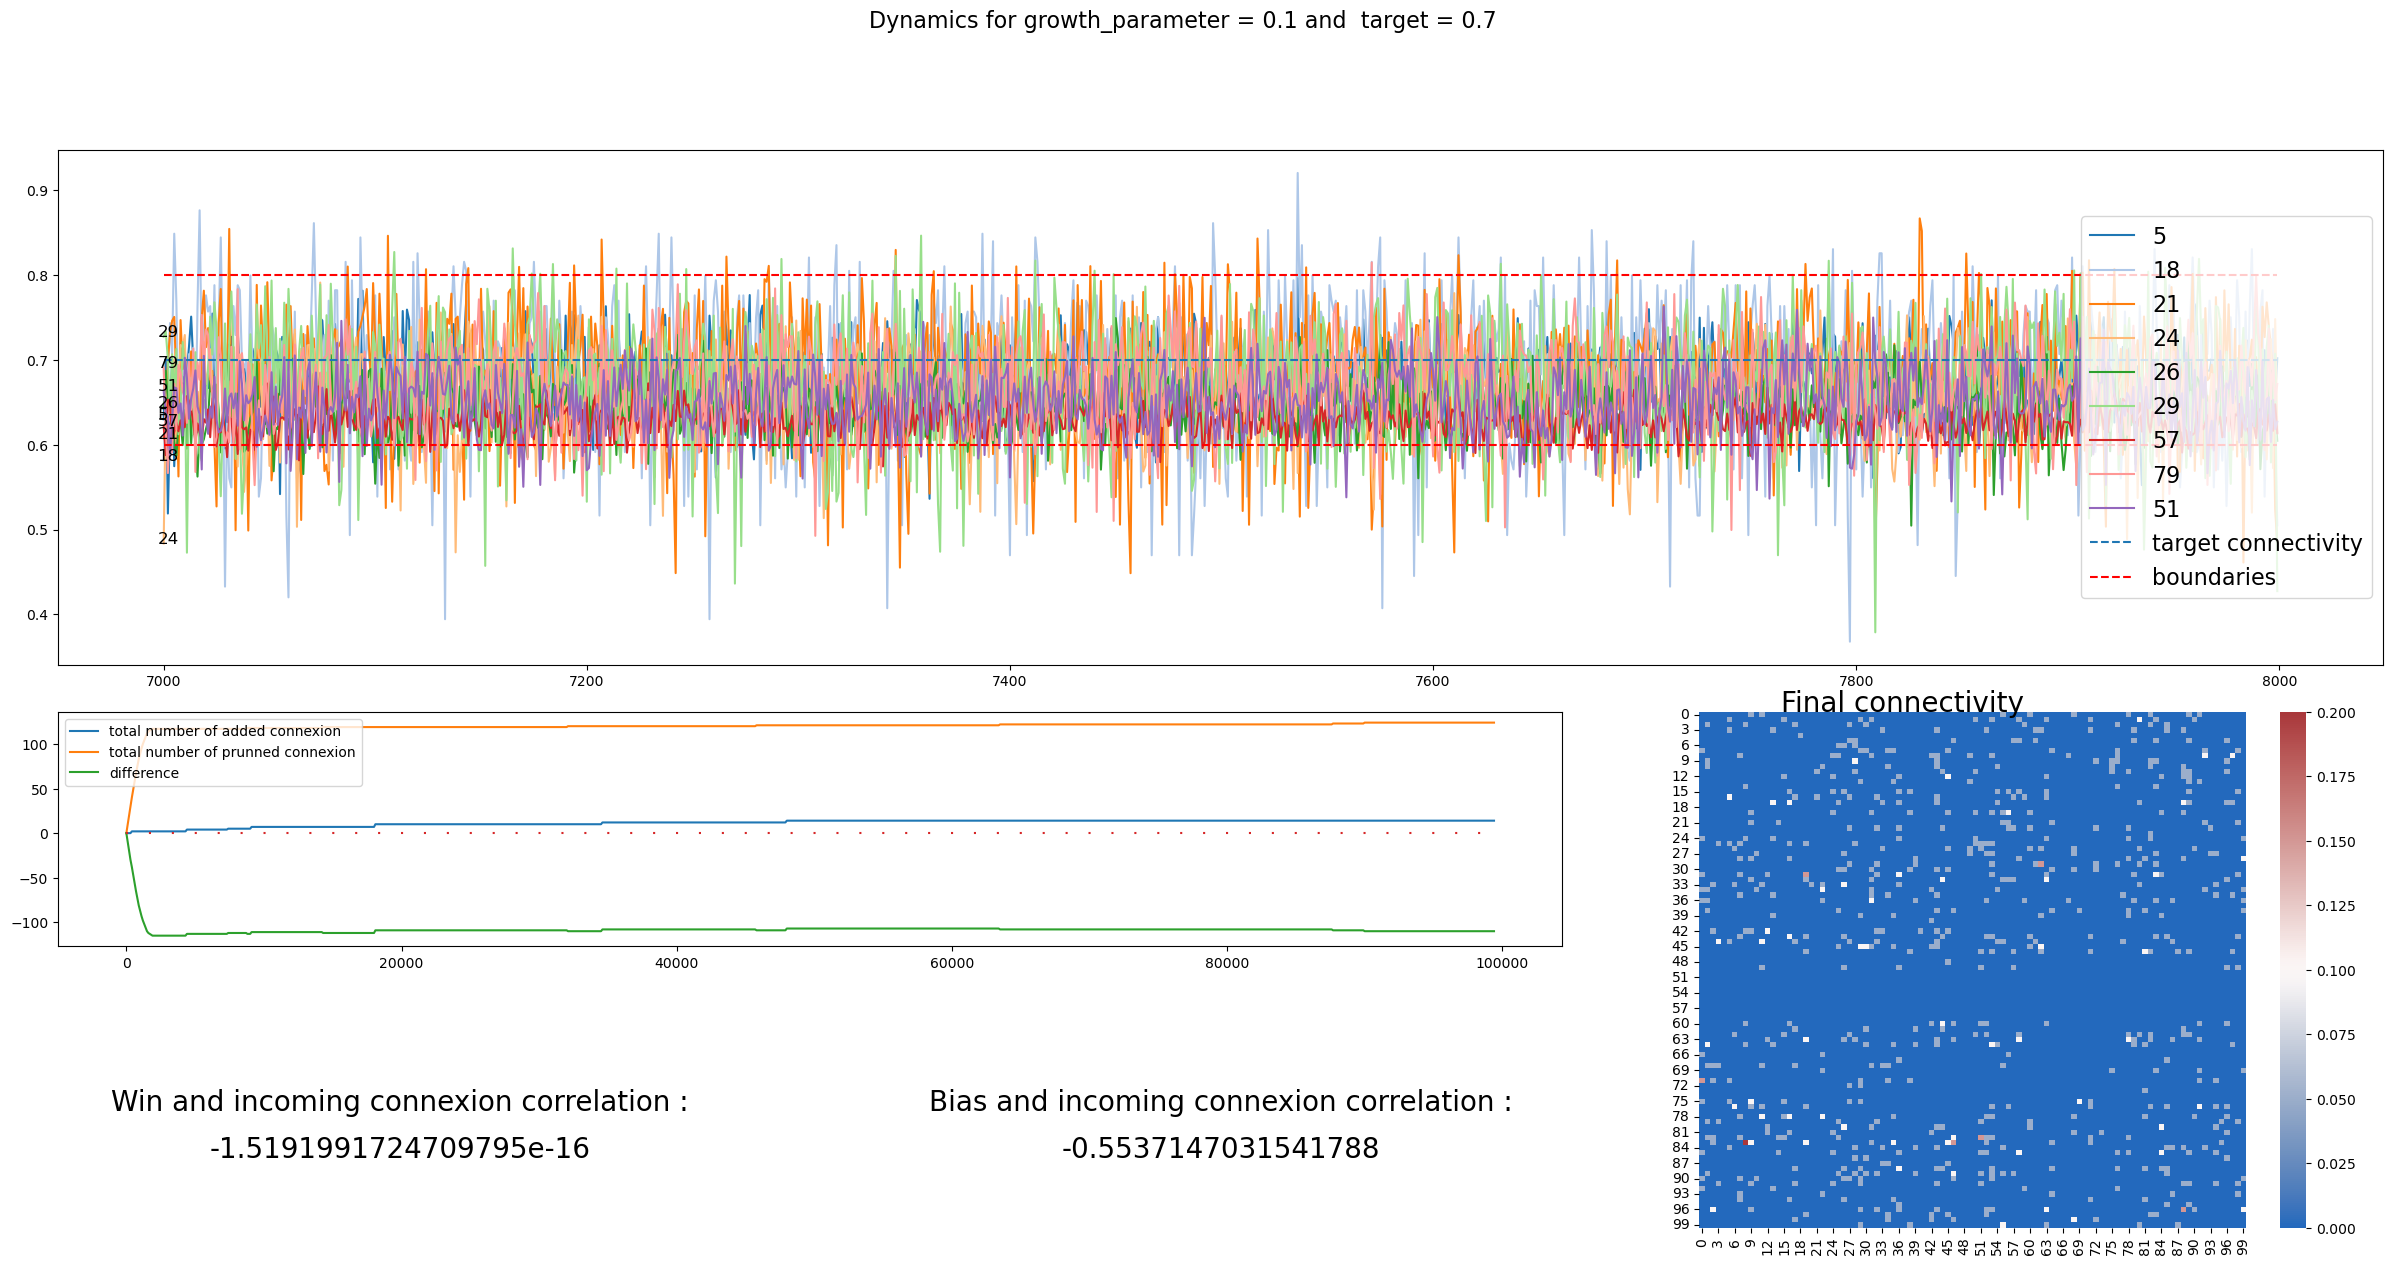

In [31]:
from math import copysign
from analysis.metrics import pearson 

plt.figure(figsize=(30,14))
plt.suptitle(f'Dynamics for growth_parameter = {growth_parameter} and  target = {target_rate}', fontsize=16)

# NEURON ACTIVITY PLOT 
ax0 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=2)
random_neurons_indices =  np.sort(np.random.randint(n_e, size=8)) #Size max is 19 because there is not enough colors
random_neurons_indices = np.append(random_neurons_indices, 51)
colors = color_palette("tab20")
# NUMBER_OF_STEP_TO_WATCH 
WATCH_FROM = 7000
WATCH_TO = 8000
neurons_evolution = np.array(state_history_e)[WATCH_FROM:WATCH_TO]
x =range(len(state_history_e))[WATCH_FROM:WATCH_TO]
j = 0
for i in random_neurons_indices:
    ax0.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    ax0.text(-3+WATCH_FROM, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1
ax0.plot(x, [target_rate]*(WATCH_TO-WATCH_FROM), linestyle = "--", label="target connectivity")
ax0.plot(x, [target_rate+growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--", label="boundaries")
ax0.plot(x, [target_rate-growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--")
# to watch the inputs simultaneously
# ax0.plot(x, inputs1[0, WATCH_FROM:WATCH_TO], color="blue", linestyle = "--")

plt.legend(fontsize=16, loc="right")


# TOTAL ADDITION AND PRUNING OF CONNEXIONS 
ax1 = plt.subplot2grid((4, 3), (2, 0), colspan=2)
ax1.plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
ax1.plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
ax1.plot(np.arange(step)*INCREMENT, add-prun, label="difference")
ax1.plot(np.arange(step)*INCREMENT, [0]*step, linestyle=(0, (1, 10)))
ax1.legend()

# CONNEXION MATRICE
ax2 = plt.subplot2grid((4, 3), (2, 2), rowspan=2)
heatmap(W_ee_adsp_hebbian.todense(), cmap=color_palette("vlag", as_cmap=True), ax = ax2)
ax2.text(15,0, 'Final connectivity',fontsize=20)

ax3 = plt.subplot2grid((4, 3), (3, 0))
ax3.text(0.5, 0.5, 'Win and incoming connexion correlation :',fontsize=20,horizontalalignment='center',
        transform=ax3.transAxes)
ax3.text(0.5, 0.3, pearson(Win_e.A, incoming_connexion_count_history[-1]),fontsize=20,horizontalalignment='center',
        transform=ax3.transAxes)
ax3.axis('off')

ax4 = plt.subplot2grid((4, 3), (3, 1))
ax4.text(0.5, 0.5, 'Bias and incoming connexion correlation :',fontsize=20,horizontalalignment='center',
        transform=ax4.transAxes)
ax4.text(0.5, 0.3, pearson(bias_e, incoming_connexion_count_history[-1]),fontsize=20,horizontalalignment='center',
        transform=ax4.transAxes)
ax4.axis('off')

plt.show()

<AxesSubplot: >

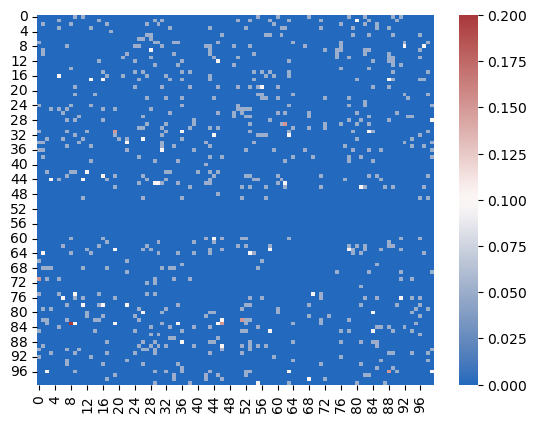

In [32]:
heatmap(W_ee_adsp_hebbian.todense(), cmap=color_palette("vlag", as_cmap=True))

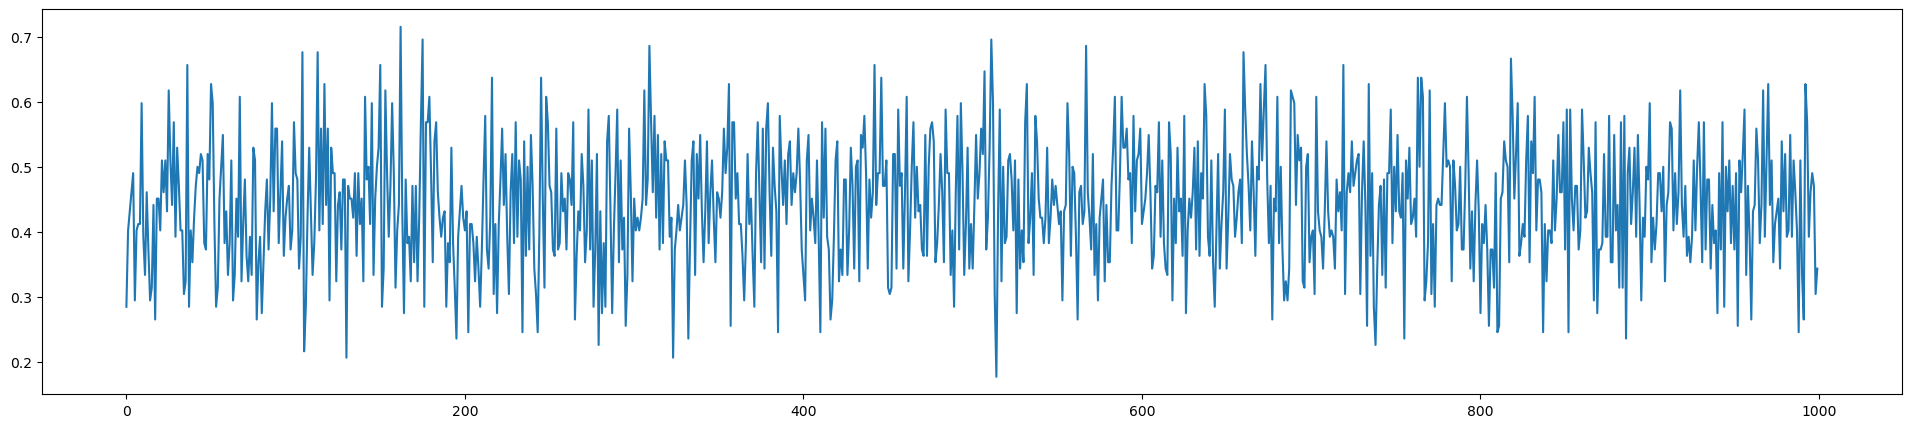

In [33]:
from scipy.stats import poisson

mu = 100
timesteps = 100000

U = poisson.rvs(mu, size=[timesteps, n_e], random_state = SEED)[np.newaxis].T

# rescale between 0 and 1
inputs3 = (U - U.min()) / (U.max() - U.min())

plt.figure(figsize=(24,5))
plt.plot(range(1000), inputs3[52,16000:17000])
plt.show()

In [34]:
u_train3 = inputs3.copy()

step=0

total_add = 0
total_prun = 0
add = []
prun = []
mean_prun = []

state_history_e = []
delta_z_e_history = []
train_length = len(u_train3[1, :])

while train_length > 500:
     # For excitatory neurons (We and Wie)
    delta_z_e = compute_synaptic_change(state_history_e[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
    W_ee_adsp_hebbian, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_adsp_hebbian, state_e, delta_z_e, VALUE)
    delta_z_e_history.append(delta_z_e)
    
    # For inhibitory neurons (Wei)
    # delta_z_i = compute_synaptic_change(state_history_i[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
    # W_ei_adsp, _, nb_new_add_i, nb_new_prun_i = adsp(W_ei_adsp, state_i, delta_z_i, VALUE)

    for i in range(INCREMENT):
        state_e = update_reservoir(W_ee_adsp_hebbian, Win_e_adsp_hebbian, u_train3[:, i], state_e, leaky_rate, bias_e, activation_function)
        state_history_e.append(state_e)
    u_train3 = u_train3[:, INCREMENT:]
    train_length = len(u_train3[1, :])


    total_add += nb_new_add_e # + nb_new_add_i
    total_prun += nb_new_prun_e # + nb_new_prun_i
    add.append(total_add)
    prun.append(total_prun)
    step +=1
add = np.array(add)
prun = np.array(prun)

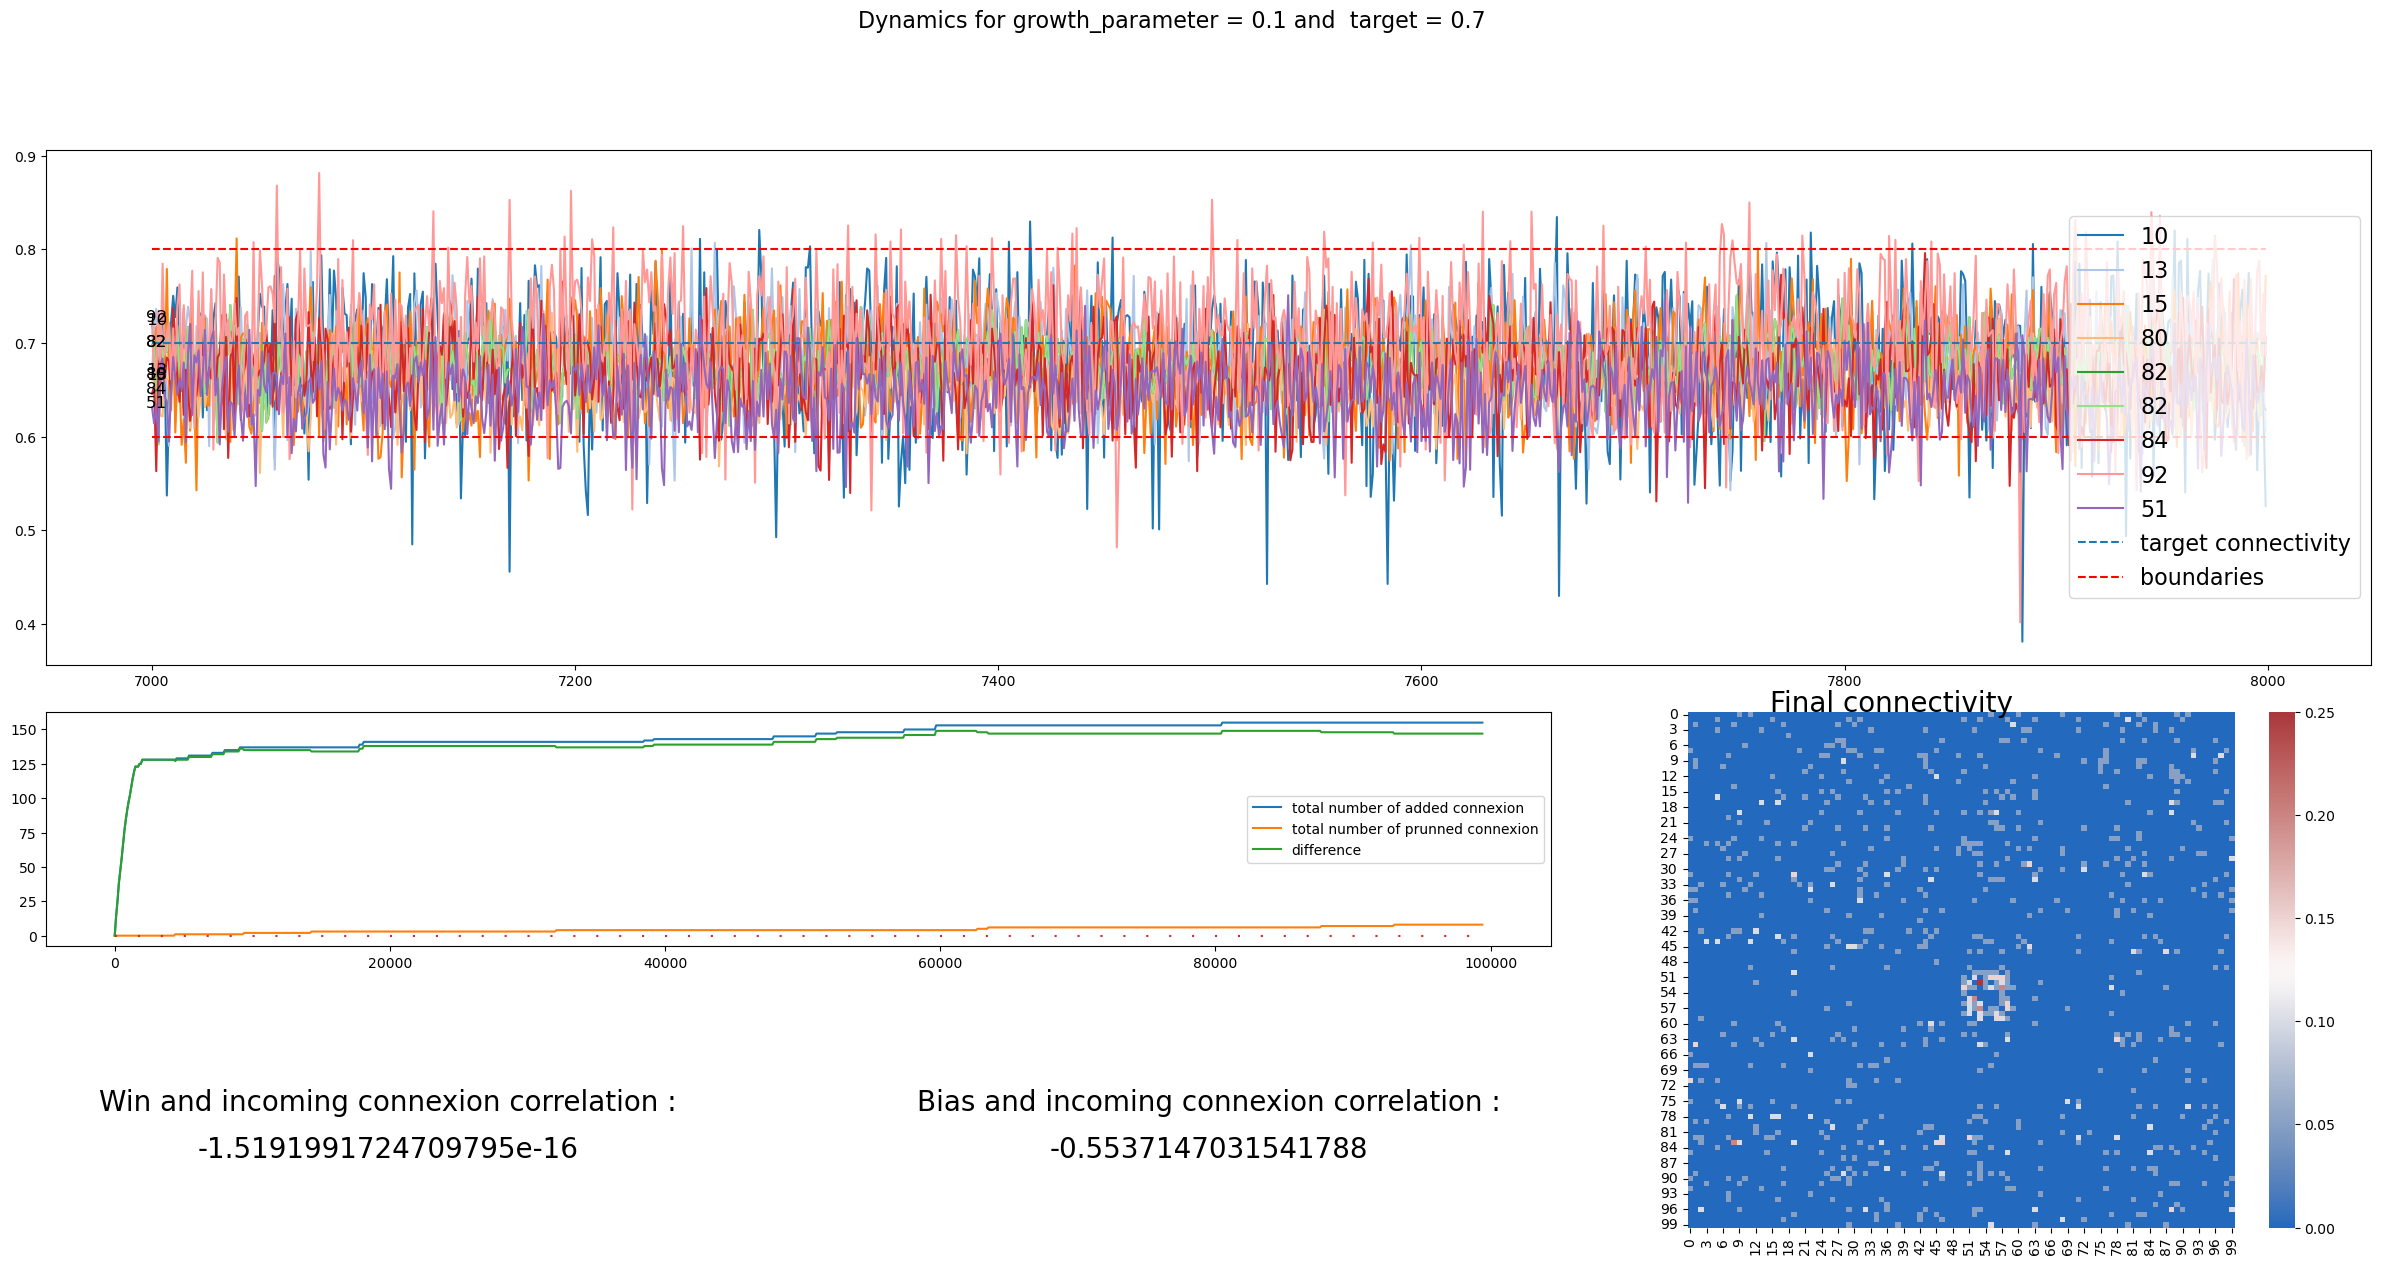

In [35]:
from math import copysign
from analysis.metrics import pearson 

plt.figure(figsize=(30,14))
plt.suptitle(f'Dynamics for growth_parameter = {growth_parameter} and  target = {target_rate}', fontsize=16)

# NEURON ACTIVITY PLOT 
ax0 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=2)
random_neurons_indices =  np.sort(np.random.randint(n_e, size=8)) #Size max is 19 because there is not enough colors
random_neurons_indices = np.append(random_neurons_indices, 51)
colors = color_palette("tab20")
# NUMBER_OF_STEP_TO_WATCH 
WATCH_FROM = 7000
WATCH_TO = 8000
neurons_evolution = np.array(state_history_e)[WATCH_FROM:WATCH_TO]
x =range(len(state_history_e))[WATCH_FROM:WATCH_TO]
j = 0
for i in random_neurons_indices:
    ax0.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    ax0.text(-3+WATCH_FROM, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1
ax0.plot(x, [target_rate]*(WATCH_TO-WATCH_FROM), linestyle = "--", label="target connectivity")
ax0.plot(x, [target_rate+growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--", label="boundaries")
ax0.plot(x, [target_rate-growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--")
# to watch the inputs simultaneously
# ax0.plot(x, inputs1[0, WATCH_FROM:WATCH_TO], color="blue", linestyle = "--")

plt.legend(fontsize=16, loc="right")


# TOTAL ADDITION AND PRUNING OF CONNEXIONS 
ax1 = plt.subplot2grid((4, 3), (2, 0), colspan=2)
ax1.plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
ax1.plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
ax1.plot(np.arange(step)*INCREMENT, add-prun, label="difference")
ax1.plot(np.arange(step)*INCREMENT, [0]*step, linestyle=(0, (1, 10)))
ax1.legend()

# CONNEXION MATRICE
ax2 = plt.subplot2grid((4, 3), (2, 2), rowspan=2)
heatmap(W_ee_adsp_hebbian.todense(), cmap=color_palette("vlag", as_cmap=True), ax = ax2)
ax2.text(15,0, 'Final connectivity',fontsize=20)

ax3 = plt.subplot2grid((4, 3), (3, 0))
ax3.text(0.5, 0.5, 'Win and incoming connexion correlation :',fontsize=20,horizontalalignment='center',
        transform=ax3.transAxes)
ax3.text(0.5, 0.3, pearson(Win_e.A, incoming_connexion_count_history[-1]),fontsize=20,horizontalalignment='center',
        transform=ax3.transAxes)
ax3.axis('off')

ax4 = plt.subplot2grid((4, 3), (3, 1))
ax4.text(0.5, 0.5, 'Bias and incoming connexion correlation :',fontsize=20,horizontalalignment='center',
        transform=ax4.transAxes)
ax4.text(0.5, 0.3, pearson(bias_e, incoming_connexion_count_history[-1]),fontsize=20,horizontalalignment='center',
        transform=ax4.transAxes)
ax4.axis('off')

plt.show()

<AxesSubplot: >

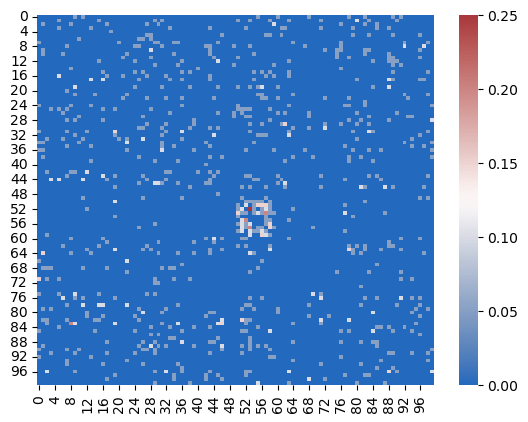

In [36]:
heatmap(W_ee_adsp_hebbian.todense(), cmap=color_palette("vlag", as_cmap=True))

# Measurement
We create a comparable matrice for measurment

In [ ]:
eigen_adsp = sparse.linalg.eigs(W_ee_adsp, k=1, which="LM", maxiter=W_ee_adsp.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_adsp = max(abs(eigen_adsp))
sr_adsp

## Richness in reservoir

### Memory capacity

$$  y_{d_i} = \prod_i{P_{d_i}(u(t-i))}$$

#### Without adsp

In [ ]:
import analysis.capacities as CAP
# Helper function to use the capacities data structure coming out of the iterator
# cap2vec collates all capacities with same maximal delay and degree up to given maximal values
def cap2vec(capacities,maxdel=1000,maxdeg=10):
    vec = np.zeros((maxdel,maxdeg))
    for idx in range(len(capacities)):
        delay=capacities[idx]['delay']
        degree=capacities[idx]['degree']
        if (delay<=maxdel) and (degree<=maxdeg):
            vec[delay-1,degree-1]+=capacities[idx]['score']
    return vec

maxdel = 15
maxdeg = 7

TRYOUT = 10
V = np.zeros((maxdel, maxdeg))
for i in range(TRYOUT):
    print("\nRound :", i)
    # We generate a network randomly with same spectral radius and same connectivity as the ADSP generated one
    connectivity_desired =  W_ee_adsp.count_nonzero() / (W_ee_adsp.shape[0] * W_ee_adsp.shape[1])
    _, W_ee_w, _ =  init_matrices(n_e, input_connectivity, connectivity_desired, spectral_radius)
    eigen_adsp = sparse.linalg.eigs(W_ee_adsp, k=1, which="LM", maxiter=W_ee_adsp.shape[0] * 20, tol=0.1, return_eigenvectors=False)
    sr_adsp = max(abs(eigen_adsp))
    eigen_w = sparse.linalg.eigs(W_ee_w, k=1, which="LM", maxiter=W_ee_w.shape[0] * 20, tol=0.1, return_eigenvectors=False)
    sr_w = max(abs(eigen_w))
    W_ee_w = W_ee_w*sr_adsp/sr_w

    # Number of time steps: you can use 1e5 for quick-and-dirty, but 1e6 is better
    warmup_steps = 500
    warmups = 2.0*np.random.rand(warmup_steps,1)-1.0

    # Important: capacity theory with Legendre polynomials assumes uniform random inputs in [-1,1]
    steps = 1000000
    inputs = 2.0*np.random.rand(steps,1)-1.0

    for i in range(warmup_steps):
        state_e, state_i = update_ei_reservoir(W_ee_w, W_ie, W_ei, Win_e, warmups[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)

    capa_history_e = []
    for i in range(steps):
        state_e, state_i = update_ei_reservoir(W_ee_w, W_ie, W_ei, Win_e, inputs[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
        capa_history_e.append(state_e)
    capa_history_e = np.array(capa_history_e)
    connectivity_desired
    
    # Measallcapsure capacities on inputs and states after removing a "warmup period"
    # If you require more extensive printed output of individual capacities:
    # set verbose = 1
    Citer=CAP.capacity_iterator(maxdeg=7, maxdel=100)#, verbose = 1)
    totalcap,allcaps,numcaps,nodes = Citer.collect(inputs,capa_history_e)

    print("\nMeasured ",numcaps," capacities above threshold.\nTotal capacity = ",totalcap)

    V = V  + cap2vec(allcaps,maxdel = maxdel, maxdeg = maxdeg)
V = V/TRYOUT
    

In [ ]:
heatmap(W_ee_w.todense(), cmap=color_palette("vlag", as_cmap=True))

In [ ]:
plt.figure(figsize=(2,4))

values = np.sum(V, axis=0)
height = 0
for i, v in enumerate(values):
    plt.bar(0, v, bottom=height, color=plt.cm.tab10(i))
    height = height + v

plt.xticks([0, 1], ('normal', 'adsp'))
plt.show()

In [ ]:

# maxdel = 15
# maxdeg = 10
# V = cap2vec(allcaps,maxdel = maxdel, maxdeg = maxdeg)

delrange = np.arange(1,maxdel+1)
totcap = np.sum(V,axis=1)
plt.figure(figsize=(3,4))
plt.semilogy(delrange,V[:,0],label='Linear')
plt.plot(delrange,V[:,1],label='Qadratic')
plt.plot(delrange,V[:,2],label='Qubic')
plt.plot(delrange,V[:,3],label='4')
plt.plot(delrange,V[:,4],label='5')

plt.xlabel('Maximal delay')
plt.ylabel('Total capacity')

plt.show()



#### With adsp

In [ ]:
import connexion_generation.bounded_adsp
import connexion_generation.utility

import reservoir.reservoir
from reservoir.reservoir import update_reservoir
reload(reservoir.reservoir)

# Parameters
# The parameters you want to see the influence
growth_parameter = 0.1
target_rate=0.7

INCREMENT = 100
VALUE = 0.05

V_adsp = []

W_ee_adsp_history = []

MAX_NUMBERS_CONNECTIONS = [2, 8, 12, 20]
TRYOUT = 1
MAX_DEG = 6
MAX_DEL = 20
j = 0 
for max_number_connection in MAX_NUMBERS_CONNECTIONS:
    V_adsp.append(np.zeros((maxdel, maxdeg)))
    for i in range(TRYOUT):
        print("\nRound :", i)
        # Initialisation
        W_ee_adsp = W_ee.copy()
        u_train1 = inputs1.copy()
        state_e = last_state_e
        Win_e_adsp = Win_e

        # last_state
        last_state_e = np.random.uniform(0, 1, n_e)
        step=0

        state_history_e = []
        delta_z_e_history = []

        for i in range(INCREMENT*5):
            state_e = update_reservoir(W_ee_adsp, Win_e_adsp, u_train1[:, i], state_e, leaky_rate, bias_e, activation_function)
            state_history_e.append(state_e)
        u_train1 = u_train1[:, INCREMENT * 5:]


        train_length = len(u_train1[1, :])
        

        while train_length > 10000:
             # For excitatory neurons (We)
            delta_z_e = compute_synaptic_change(state_history_e[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
            W_ee_adsp, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_adsp, state_e, delta_z_e, VALUE, max_connections = max_number_connection)
            delta_z_e_history.append(delta_z_e)

            for i in range(INCREMENT):
                state_e = update_reservoir(W_ee_adsp, Win_e_adsp, u_train1[:, i], state_e, leaky_rate, bias_e, activation_function)
                state_history_e.append(state_e)
            u_train1 = u_train1[:, INCREMENT:]
            train_length = len(u_train1[1, :])

        W_ee_adsp_history.append(W_ee_adsp)
        
        warmup_steps = 500
        warmups = 2.0*np.random.rand(warmup_steps,1)-1.0

        # Important: capacity theory with Legendre polynomials assumes uniform random inputs in [-1,1]
        steps = 1000000
        inputs = 2.0*np.random.rand(steps,1)-1.0

        state_e_adsp = last_state_e
        for i in range(warmup_steps):
            state_e_adsp = update_reservoir(W_ee_adsp, Win_e_adsp, warmups[i], state_e_adsp, leaky_rate, bias_e, activation_function)

        capa_history_e_adsp = []
        for i in range(steps):
            state_e_adsp = update_reservoir(W_ee_adsp, Win_e_adsp, inputs[i], state_e_adsp, leaky_rate, bias_e, activation_function)
            capa_history_e_adsp.append(state_e_adsp)
        capa_history_e_adsp = np.array(capa_history_e_adsp)

        # Measallcapsure capacities on inputs and states after removing a "warmup period"
        # If you require more extensive printed output of individual capacities:
        # set verbose = 1
        Citer=CAP.capacity_iterator(maxdeg=MAX_DEG, maxdel=MAX_DEL)#, verbose = 1)
        totalcap_adsp,allcaps_adsp,numcaps_adsp,nodes = Citer.collect(inputs,capa_history_e_adsp)

        print("\nMeasured ",numcaps_adsp," capacities above threshold.\nTotal capacity = ",totalcap_adsp)
        V_adsp[j] = V_adsp[j]  + cap2vec(allcaps_adsp,maxdel = MAX_DEL, maxdeg = MAX_DEG)
    V_adsp[j] = V_adsp[j]/TRYOUT
    j = j+1

In [ ]:
heatmap(W_ee_adsp_history[-1].todense(), cmap=color_palette("vlag", as_cmap=True))

eigen_w = sparse.linalg.eigs(W_ee_adsp_history[3], k=1, which="LM", maxiter=W_ee_w.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_w = max(abs(eigen_w))
sr_w

In [ ]:
V_adsp_array = np.array(V_adsp)


In [ ]:
plt.figure(figsize=(6,4))

for j, m in enumerate(MAX_NUMBERS_CONNECTIONS):
    values_adsp = np.sum(V_adsp_array[:, :, :6][j], axis=0)
    values_adsp = np.append(values_adsp, 100-np.sum(values_adsp)) 
    height = 0
    for i, v in enumerate(values_adsp):
        plt.bar(j, v, bottom=height, color=plt.cm.tab10(i))
        plt.text(j-0.05, height+v/2-1, str(int(v)))
        height = height + v

plt.xticks(range(len(MAX_NUMBERS_CONNECTIONS)), MAX_NUMBERS_CONNECTIONS)
plt.ylim(0, 100)
plt.show()
maxdel

In [ ]:

delrange = np.arange(1,maxdel+1)
totcap = np.sum(V_adsp,axis=1)
plt.figure(figsize=(3,4))
plt.semilogy(delrange,V_adsp[:,0],llabel='Linear')
plt.plot(delrange,V_adsp[:,1],label='Qadratic')
plt.plot(delrange,V_adsp[:,2],label='Qubic')
plt.plot(delrange,V_adsp[:,3],label='4')
plt.plot(delrange,V_adsp[:,4],label='5')

# legend_elements = [plt.Line2D([0], [0], color='tab:blue', label='linear'),
#                    plt.Line2D([0], [0], color='tab:orange', label='Qadratic'),
#                    plt.Line2D([0], [0], color='tab:green', label='Qubic'),
#                    plt.Line2D([0], [0], color='tab:red', label='4'),
#                    plt.Line2D([0], [0], color='tab:purple', label='5'),
#                    plt.Line2D([0], [0], color='tab:brown', label='6'),
#                    plt.Line2D([0], [0], color='tab:pink', label='7'),
#                    plt.Line2D([0], [0], color='tab:gray', label='8 and above')]


plt.xlabel('Maximal delay')
# plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.1,1.6))
plt.show()

#### Comparaison

In [ ]:
print(values)
print(values_adsp)

In [ ]:
plt.figure(figsize=(2,4))

values = np.sum(V, axis=0)
values = np.append(values, 100-np.sum(values)) 
values_adsp = np.sum(V_adsp, axis=0)
values_adsp = np.append(values_adsp, 100-np.sum(values_adsp)) 

height = 0
for i, v in enumerate(values):
    plt.bar(0, v, bottom=height, color=plt.cm.tab10(i))
    height = height + v

height = 0
for i, v in enumerate(values_adsp):
    plt.bar(1, v, bottom=height, color=plt.cm.tab10(i))
    height = height + v

plt.xticks([0, 1], ('normal', 'adsp'))
plt.ylim(0, 100)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
plt.figure(figsize=(4,3))

plt.plot(range(12),V[0:12,0],label='random', color="blue", marker="X")
plt.plot(range(12),V_adsp[0:12,0],label='ADSP', marker=".")
plt.grid()
plt.xlabel('Delay')
plt.ylabel('Capacity')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()


### Spectral radius

In [ ]:
eigen_adsp = sparse.linalg.eigs(W_ee_adsp, k=1, which="LM", maxiter=W_ee_adsp.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_adsp = max(abs(eigen_adsp))
sr_adsp

In [ ]:
eigen_w = sparse.linalg.eigs(W_ee_w, k=1, which="LM", maxiter=W_ee_w.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_w = max(abs(eigen_w))
sr_w

### Uncoupled dynamics

number of the principal components (i.e. orthogonal diretions of variability) that are able to explain the most of the variance in the reservoir state space

https://arxiv.org/pdf/1903.05174.pdf

$$ UD =  \underset{d}{\arg\min} \{ \sum\limits_{k=1}^d R_k|\sum\limits_{k=1}^dR_k ≥ A\}$$

with  $R_k = \frac{σ_k}{\sum\limits_{j=1}^{N_R}σ_j} $

In [ ]:
from analysis.metrics import uncoupled_dynamics
from reservoirpy.datasets import mackey_glass
from reservoirpy.observables import nrmse, rsquare

timesteps = 20000
warmup_steps = 500
steps = timesteps + warmup_steps
tau = 17
# X = mackey_glass(steps, tau=tau)
X = 2.0*np.random.rand(steps,1)-1.0
# rescale between -1 and 1
inputs = 2 * (X - X.min()) / (X.max() - X.min()) - 1

## Calculous for simple RNN
state_e = last_state_e
state_i = last_state_i
history_e = []
for i in range(steps):
    state_e, state_i = update_ei_reservoir(W_ee_w, W_ie, W_ei, Win_e, inputs[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
    history_e.append(state_e)
history_e = np.array(history_e)[warmup_steps:]
UD = uncoupled_dynamics(history_e, temp = 5000, A= 0.9)
print(UD)

## Calculous for adsp RNN
state_e_adsp = last_state_e
state_i_adsp = last_state_i
history_e_adsp = []
for i in range(steps):
    state_e_adsp, state_i_adsp = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e, inputs[i], state_e_adsp, state_i_adsp, leaky_rate, bias_e, bias_i, activation_function)
    history_e_adsp.append(state_e_adsp)
history_e_adsp = np.array(history_e_adsp)[warmup_steps:]
UD_adsp = uncoupled_dynamics(history_e_adsp, temp = 5000, A= 0.9)

print(UD_adsp)


### Pearson coeffcients

$$ corr(x_i(t), x_k(t+1))) = \frac{\sum\limits_{t=1}^{T-1}{(x_i(t)-\bar{x_i})(x_k(t)-\bar{x_k})}} {\sqrt{\sum\limits_{t=1}^{T-1}{(x_i(t)-\bar{x_i})^2}}\sqrt{\sum\limits_{t=1}^{T-1}{(x_k(t)-\bar{x_k})^2}}} $$

In [ ]:
from analysis.metrics import pearson_matrix

plt.figure(figsize=(12,4))

ax0 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
Pearson = pearson_matrix(history_e[:20000,])
heatmap(Pearson)

ax1 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
Pearson = pearson_matrix(history_e_adsp[:20000,])
heatmap(Pearson)

The mean Pearson coefficient is given by

$$ \bar{Corr} = \frac{1}{N^2} \sum\limits_{i=1}^{N}\sum\limits_{k=1}^{N}corr(x_i(t), x_k(t+1)) $$

In [ ]:
print(np.mean(pearson_matrix(history_e[:20000,])))
print(np.mean(pearson_matrix(history_e_adsp[:20000,])))

### Average State Entropy

efficient estimator of Renyi’s quadratic entropy 

https://arxiv.org/pdf/1903.05174.pdf

https://www.researchgate.net/publication/2818138_Information-Theoretic_Learning_Using_Renyi's_Quadratic_Entropy4

*"H(t) which is the sum of all pairs of interactions can be regarded as an overall potential energy of the data set. We will call this potential energy an information potential (IP). So **maximizing entropy** becomes equivalent to **minimizing information potential**"*


https://ia800704.us.archive.org/view_archive.php?archive=/24/items/wikipedia-scholarly-sources-corpus/10.1162.zip&file=10.1162%252Fneco.2007.19.1.111.pdf



$$H(t) = −log( \frac{1}{N_R^2}\sum\limits_{j=1}^{N_R}(\sum\limits_{i=1}^{N_R}G _{0.3}(x_j(t) - x_i (t))))$$

In [ ]:
from analysis.metrics import renyi_entropy

In [ ]:
print(np.mean(renyi_entropy(history_e[:20000,])))
print("adsp", np.mean(renyi_entropy(history_e_adsp[:20000,])))

## Topology

In [ ]:
%matplotlib inline
%matplotlib --list

In [ ]:
from analysis.topology import create_network, draw_network

g = create_network(W_ee_w, Win_e)
draw_network(g, n_e)

In [ ]:
g = create_network(W_ee_adsp)
draw_network(g, n_e)

### Connexion number histogram

In [ ]:
# Incoming connexions histogram
def plot_incoming_co_histogram(W_ee, W_ei, W_ie, ax=None):
    connections_ee = np.sum(np.where(W_ee <= 0, W_ee, 1), axis=1)
    connections_ie = np.sum(np.where(W_ie <= 0, W_ie, 1), axis=1)
    incoming_co = connections_ee + connections_ie
#    print(incoming_co)
    n_bins = int(np.max(incoming_co)+1)
    if ax == None:
        plt.figure()
        ax = plt
    ax.hist(incoming_co, bins=n_bins, ec="yellow")

# Incoming connexions histogram
def plot_outcoming_co_histogram(W_ee, W_ei, W_ie, ax=ax1):
    connections_ee = np.sum(np.where(W_ee <= 0, W_ee, 1), axis=0)
    connections_ie = np.sum(np.where(W_ei <= 0, W_ei, 1), axis=0)
    incoming_co = connections_ee + connections_ie
#    print(incoming_co)
    n_bins = int(np.max(incoming_co)+1)
    if ax == None:
        plt.figure()
        ax = plt
    ax.hist(incoming_co, bins=n_bins, ec="yellow")

fig = plt.figure(figsize=(16,8))

gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
plot_incoming_co_histogram(W_ee.A, W_ei.A, W_ie.A, ax=ax1)
ax1.set_ylabel("connexions before adsp")
ax1.set_title("Incoming connexions")


ax2 = fig.add_subplot(gs[0, 1])
plot_outcoming_co_histogram(W_ee.A, W_ei.A, W_ie.A, ax=ax2)
ax2.set_title("Outcoming connexions")

ax3 = fig.add_subplot(gs[1, 0])
plot_incoming_co_histogram(W_ee_adsp.A, W_ei_adsp.A, W_ie_adsp.A, ax=ax3)
ax3.set_ylabel("connexions after adsp")

ax4 = fig.add_subplot(gs[1, 1])
plot_outcoming_co_histogram(W_ee_adsp.A, W_ei_adsp.A, W_ie_adsp.A, ax=ax4)


In [ ]:
from graph_tool.all import GraphView, corr_hist
g = create_network(W_ee_w)

gv= GraphView(g, directed=False)
h = corr_hist(g, "out", "out")

plt.clf()
plt.xlabel("Source out-degree")

plt.ylabel("Target out-degree")

plt.imshow(h[0].T, interpolation="nearest", origin="lower")

plt.colorbar()


### Centrality
https://graph-tool.skewed.de/static/doc/centrality.html?highlight=eigentrust#graph_tool.centrality.eigentrust

#### Katz centrality

In [ ]:
# The Katz centrality is the solution of the nonhomogeneous linear system x = alpha * A * x + betha
# https://en.wikipedia.org/wiki/Katz_centrality
# https://graph-tool.skewed.de/static/doc/centrality.html#graph_tool.centrality.katz
from graph_tool.all import katz, graph_draw, prop_to_size, arf_layout
import matplotlib

g = create_network(W_ee_w)

x = katz(g, weight=g.ep["edge_pen_weight"])
pos = arf_layout(g)

graph_draw(g, pos=pos, vertex_fill_color=x,
              vertex_size=prop_to_size(x, mi=5, ma=15),
              vcmap=matplotlib.cm.gist_heat,
              vorder=x)

#### EigenTrust

In [ ]:
# The Katz centrality is the solution of the nonhomogeneous linear system x = alpha * A * x + betha
# https://en.wikipedia.org/wiki/EigenTrust
# https://graph-tool.skewed.de/static/doc/centrality.html?highlight=eigentrust#graph_tool.centrality.eigentrust
from graph_tool.all import eigentrust, graph_draw, prop_to_size
import matplotlib

g = create_network(W_ee_w)

t = eigentrust(g, g.ep["edge_pen_weight"])
pos = arf_layout(g)

graph_draw(g, pos=pos, vertex_fill_color=t,
              vertex_size=prop_to_size(t, mi=5, ma=15),
              vcmap=matplotlib.cm.gist_heat,
              vorder=t)

### Shortest path

In [ ]:
from graph_tool.all import count_shortest_paths

g = create_network(W_ee_w)
n_paths = count_shortest_paths(g, 12, 35)

print(n_paths)

### Correlation
https://graph-tool.skewed.de/static/doc/correlations.html#graph_tool.correlations.corr_hist

In [ ]:
from graph_tool.all import GraphView, assortativity, scalar_assortativity
g = create_network(W_ee_w)

# Return the assortativity coefficient, and its variance.
gv= GraphView(g, directed=False)
print(assortativity(gv, "out"))
print(scalar_assortativity(gv, "out"))

# Benchmarks

## NARMA

https://www.sciencedirect.com/science/article/pii/S092523122100775X?via%3Dihub


In [ ]:
def createNARMA(length=10000, system_order=10, coef = [.3, .05, 1.5, .1]):

    inputs = np.random.rand(length, 1) * .5
    inputs.shape = (-1, 1)
    outputs = np.zeros((length, 1))
    for k in range(system_order - 1, length - 1):
        outputs[k + 1] = coef[0] * outputs[k] + coef[1] * \
                                           outputs[k] * np.sum(outputs[k - (system_order - 1):k + 1]) + \
                         coef[2] * inputs[k - (system_order-1)] * inputs[k] + coef[3]
    return inputs, outputs


def createNARMA10(length=10000):
    return createNARMA(length=length, system_order=10, coef=[.3, .05, 1.5, .1])


def createNARMA30(length=10000):
    return createNARMA(length=length, system_order=30, coef=[.2, .04, 1.5, .001])


timesteps = 200000 
train_samples = 10000
test_lenght = 5000

u, y = createNARMA30(timesteps)

U_train, y_train = u[:train_samples], y[:train_samples]
U_test, y_test = u[train_samples:], y[train_samples:]

%matplotlib inline
plt.figure(figsize=(16,5))
plt.plot(range(200), U_train[:200])
plt.show()

In [ ]:
# We generate a network randomly with same spectral radius and same connectivity as the ADSP generated one
connectivity_desired =  W_ee_adsp.count_nonzero() / (W_ee_adsp.shape[0] * W_ee_adsp.shape[1])
_, W_ee_w, _ =  init_matrices(n_e, input_connectivity, connectivity_desired, spectral_radius)
eigen_adsp = sparse.linalg.eigs(W_ee_adsp, k=1, which="LM", maxiter=W_ee_adsp.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_adsp = max(abs(eigen_adsp))
eigen_w = sparse.linalg.eigs(W_ee_w, k=1, which="LM", maxiter=W_ee_w.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_w = max(abs(eigen_w))
W_ee_w = W_ee_w*sr_adsp/sr_w

# Initialisation EE
Win_e_mg, W_ee_mg, bias_e =  init_matrices(n_e, 0.1, 0, spectral_radius, seed=SEED)
bias_e = bias_e*bias_scaling
Win_e_mg = Win_e_mg*input_scaling
INCREMENT = 100
VALUE = 0.05

# last_state
last_state_e = np.random.uniform(0, 1, n_e)
step=0

state_history_e = []
delta_z_e_history = []

total_add = 0
total_prun = 0
add = []
prun = []
mean_prun = []

for i in range(INCREMENT*5):
    state_e = update_reservoir(W_ee_mg, Win_e_mg, u[i], state_e, leaky_rate, bias_e, activation_function)
    state_history_e.append(state_e)
u = u[INCREMENT * 5:]


train_length = len(u)


while train_length > 100000:
    delta_z_e = compute_synaptic_change(state_history_e[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
    W_ee_mg, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_mg, state_e, delta_z_e, VALUE)
    delta_z_e_history.append(delta_z_e)

    for i in range(INCREMENT):
        state_e = update_reservoir(W_ee_mg, Win_e_mg, u[i], state_e, leaky_rate, bias_e, activation_function)
        state_history_e.append(state_e)
    u = u[INCREMENT:]
    train_length = len(u)
    
    total_add += nb_new_add_e  # + nb_new_add_i
    total_prun += nb_new_prun_e # + nb_new_prun_i
    add.append(total_add)
    prun.append(total_prun)

    step += 1
add = np.array(add)
prun = np.array(prun)

### Ridge search throughout cross validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from reservoir.losses import nrmse
from reservoir.reservoir import train_ei, run_ei

# k -fold walk forward validation
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]
            
# Parameters
mean_nrmse_list = []
ridge_coef_list = []

# Index spliting
n_fold = 4
tscv = BlockingTimeSeriesSplit(n_splits=n_fold)

for ridge_coef in np.logspace(-10, 3,  num=20):
    for train_index, val_index in tscv.split(U_train):
#        print("TRAIN:", train_index[0], val_index[-1], "VALIDATION:", test_index[0], val_index[-1]) 
        U_cv_train, U_cv_val = U_train[train_index], U_train[val_index]
        y_cv_train, y_cv_val = y_train[train_index], y_train[val_index]

        mean_nrmse = 0


        # Training output
        Wout, b_out, last_state_e, last_state_i = train_ei(W_ee_w, W_ie, W_ei, Win_e, bias_e, bias_i, U_cv_train, y_cv_train, activation_function, ridge_coef = ridge_coef)

        # Prediction
        y_cv_pred = run_ei(W_ee_w, W_ie, W_ei, Win_e, bias_e, bias_i, Wout, U_cv_val, activation_function, b_out, 1, last_state_e, last_state_i)
        mean_nrmse = mean_nrmse + float(nrmse(y_cv_pred, y_cv_val))/n_fold

    mean_nrmse_list.append(mean_nrmse)
    ridge_coef_list.append(ridge_coef)

min_val_idx = [i for i in range(len(mean_nrmse_list)) if mean_nrmse_list[i]==min(mean_nrmse_list)][0]

print(ridge_coef_list[min_val_idx])

ridge_coef = ridge_coef_list[min_val_idx]

### Train 

In [ ]:
import reservoir.reservoir
from reservoir.reservoir import train_ei
reload(reservoir.reservoir)

ridge_coef = 1e-7
# Training output
Wout, b_out, last_state_e, last_state_i = train_ei(W_ee_w, W_ie, W_ei, Win_e, bias_e, bias_i, U_train, y_train, activation_function, ridge_coef = ridge_coef)


In [ ]:
from reservoir.reservoir import run_ei
from reservoir.reservoirpy_util import plot_results, plot_readout

# Prediction
y_pred = run_ei(W_ee_w, W_ie, W_ei, Win_e, bias_e, bias_i, Wout, U_test, activation_function, b_out, 1, last_state_e, last_state_i)

plot_results(y_pred, y_test, sample=200)

In [ ]:
# Training output
Wout_adsp, b_out_adsp, last_state_e_adsp, last_state_i_adsp = train_ei(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e, bias_e, bias_i, U_train, y_train, activation_function, ridge_coef = ridge_coef)


In [ ]:
# Prediction
y_pred_adsp = run_ei(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e, bias_e, bias_i, Wout_adsp, U_test, activation_function, b_out_adsp, 1, last_state_e_adsp, last_state_i_adsp)

plot_results(y_pred_adsp, y_test, sample=200)

### Root mean square error

$RMSE=\sqrt{\frac{1}{F}\sum\limits_{t=0}^F(y_{pred}(t)−y_{test}(t))^2}$

In [ ]:
import reservoir.losses
from reservoir.losses import rmse
reload(reservoir.losses)

print("rmse", float(rmse(y_test[:100], y_pred[:100])))
print("rmse adsp", float(rmse(y_test[:100], y_pred_adsp[:100])))

## Mackey Glass

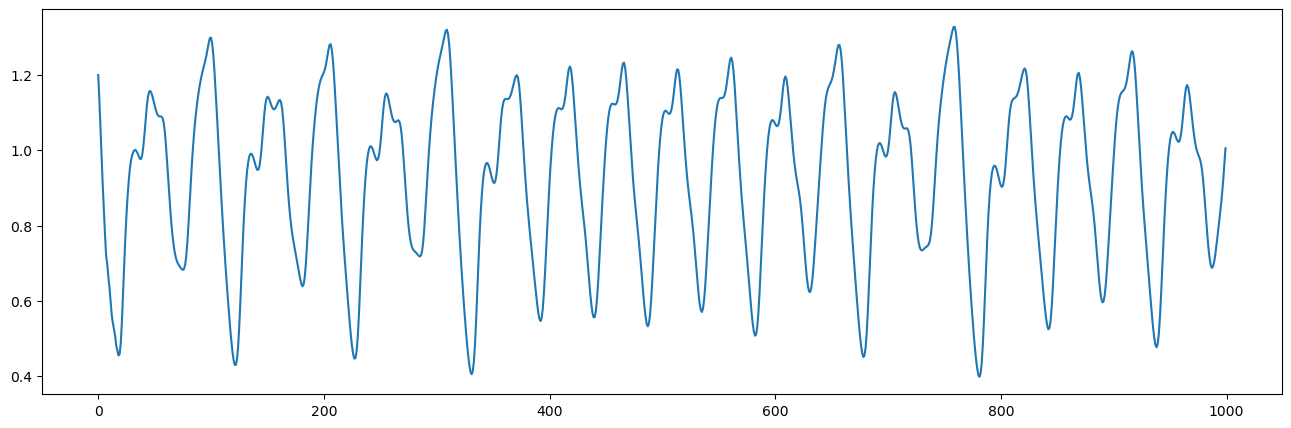

In [298]:
from reservoirpy.datasets import mackey_glass

timesteps = 10000
mg_inputs = mackey_glass(timesteps, tau=17, a=0.2, b=0.1, n=10, x0=1.2, h=1, seed=None)

%matplotlib inline
plt.figure(figsize=(16,5))
plt.plot(range(1000), mg_inputs[:1000])
plt.show()

### Creating new outputs with band filters

In [299]:
from scipy.signal import butter, lfilter
from scipy.fft import fft

def butterworth_filter(data, lowcut, highcut, fs, btype='band', order=2):
    b, a = butter(order, [lowcut/(fs/2), highcut/(fs/2)], btype=btype)
    return lfilter(b, a, data).flatten()

from_paper = [
    [ 0.015, 0.02, 0.075],
    [ 0.001, 0.001, 0.0995],
    [ 0.05, 0.005, 0.15],
    [ 0.15, 0.1, 0.55]]

filtered_data = []
filtered_data.append(butterworth_filter(mg_inputs.flatten(), 0.00001, 0 + 0.01, fs=1))
filtered_data.append(butterworth_filter(mg_inputs.flatten(), 0.04, 0.04 + 0.01, fs=1))

for frequencies in from_paper:
    for f1 in np.arange(frequencies[0], frequencies[2]+frequencies[1], frequencies[1]):
        if f1 <= 0.05:
            f2 = f1 + 0.01
        else:
            f2 = f1 + 0.1
        try:
            filtered_data.append(butterworth_filter(mg_inputs.flatten(), f1, f2, fs=1))
        except:
            print("fails" , f1)

filtered_data = np.array(filtered_data)
filtered_data[0, :] = filtered_data[0, :]*0.2 # separate input filtering so that the amplitude is similar to the other
# loop through frequency bands
# filtered_data = np.zeros((num_filters, len(mg_inputs)))
# for i in range(num_filters-1):
#     filtered_data[i, :] = butterworth_filter(mg_inputs.flatten(), cutoff_freqs[i], cutoff_freqs[i+1], fs=1)

fails 0.45000000000000007
fails 0.55


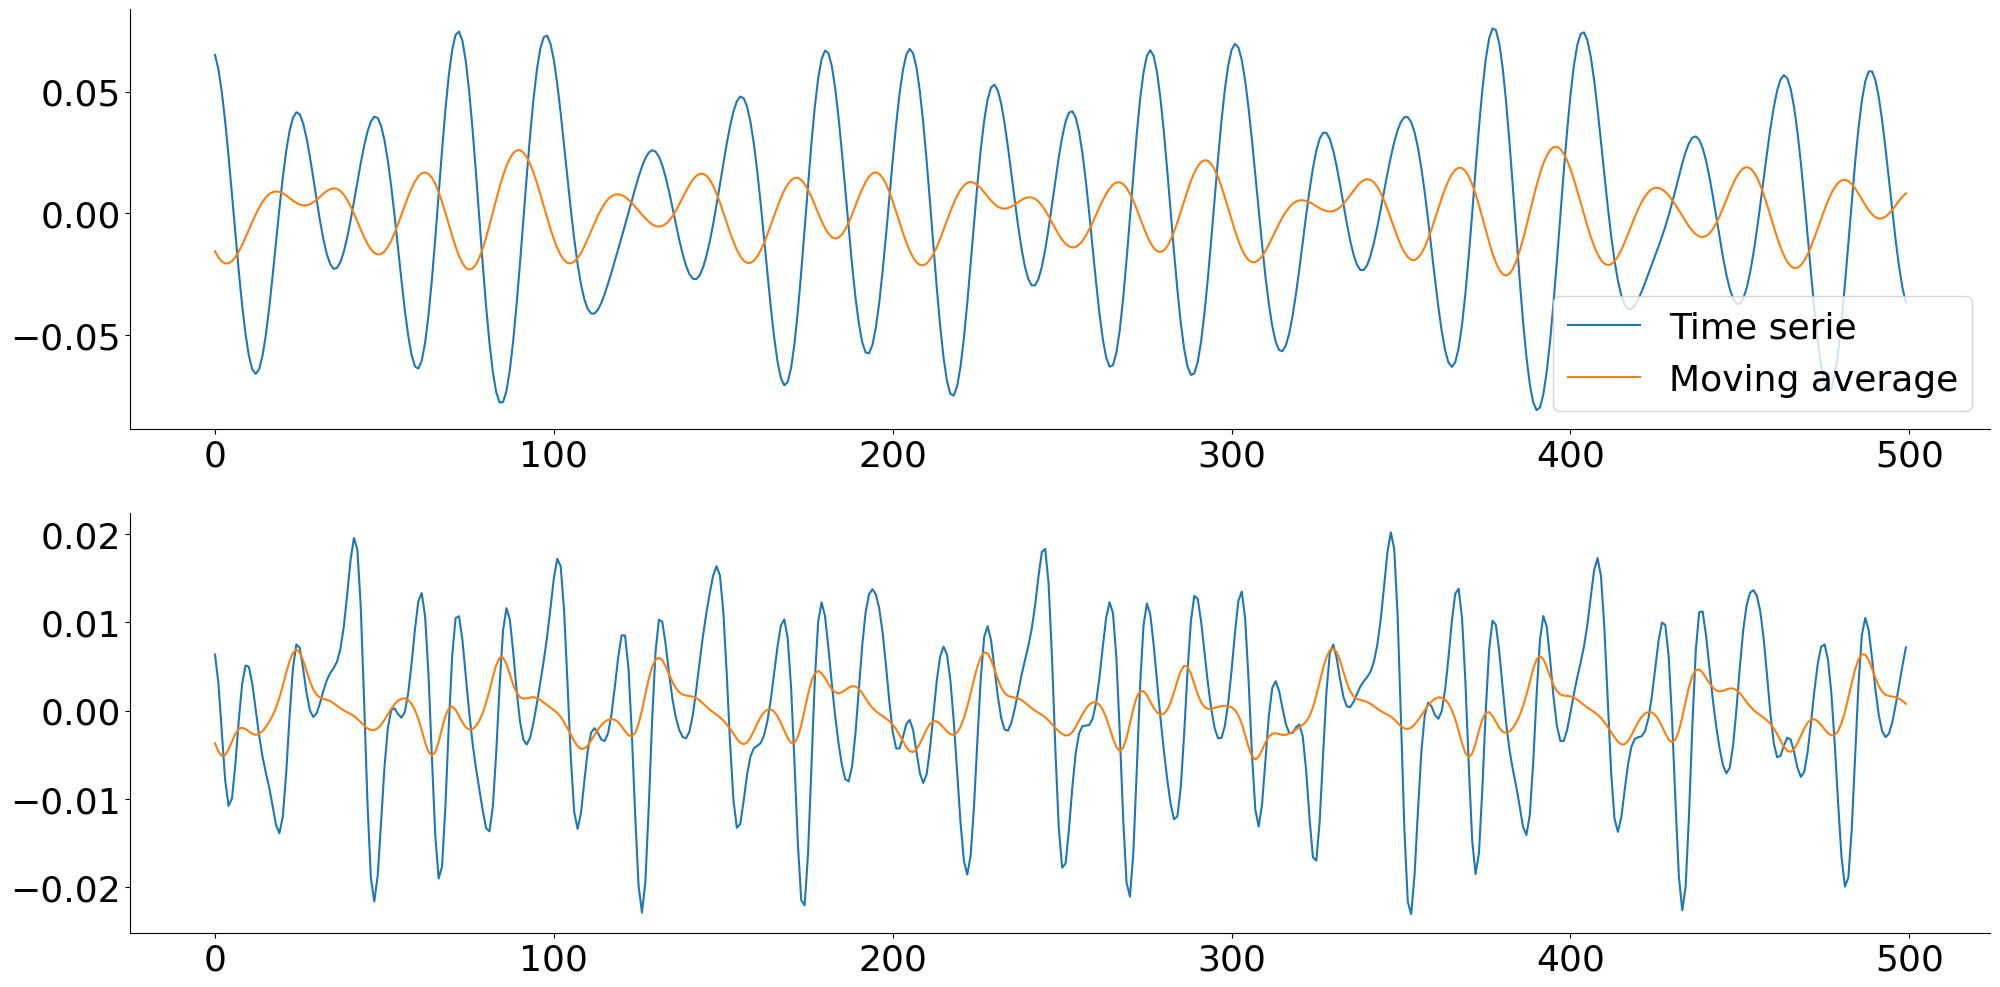

In [336]:

window_size = 20
weights = np.repeat(1.0, window_size)/window_size
ma = np.array([np.convolve(d, weights, 'valid') for d in (filtered_data)])

ax = plt.subplots(2, 1, figsize=(24,12))
ax[1][0].plot(range(500), filtered_data[3, 1000:1500], label='Time serie')
ax[1][0].plot(range(500), ma[3, 1000:1500], label='Moving average')
ax[1][0].legend(fontsize=26)
ax[1][1].plot(range(500), filtered_data[101, 1000:1500], label='Time serie')
ax[1][1].plot(range(500), ma[101, 1000:1500], label='Moving average')

ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][0].tick_params(axis='both', labelsize=26)
ax[1][1].tick_params(axis='both', labelsize=26)
plt.show()

In [301]:
n = 260

frequency_bands = np.repeat(filtered_data, 2, axis=0)
frequency_bands.shape

(260, 10000)

### Creating from ADSP + bandfilter

In [302]:
import reservoir.reservoir
from reservoir.reservoir import update_reservoir
reload(reservoir.reservoir)

INCREMENT = 20
VALUE = 0.05

leaky_rate = 1
spectral_radius = 1
bias_scaling = 1
input_scaling = 1

target_rate = 0.8
growth_parameter = 0.1

# Initialisation EE
Win_e_mg, W_ee_mg, bias_mg =  init_matrices(n, 1, 0, spectral_radius, seed=SEED)
bias_mg = bias_mg*bias_scaling
Win_e_mg = Win_e_mg*input_scaling


# last_state
state_e = np.random.uniform(0, 1, n)
step=0

state_history_4 = []

total_add = 0
total_prun = 0
add = []
prun = []

In [303]:

for i in range(INCREMENT*5):
    state_e = update_reservoir(W_ee_mg, Win_e_mg, frequency_bands[:, i], state_e, leaky_rate, bias_mg, activation_function)
    state_history_e.append(state_e)
frequency_bands = frequency_bands[:, INCREMENT * 5:]
train_length = len(frequency_bands[1,:])

while train_length > 5000:
    delta_z_e = compute_synaptic_change(state_history_e[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
    W_ee_mg, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_mg, state_e, delta_z_e, VALUE)

    for i in range(INCREMENT):
        state_e = update_reservoir(W_ee_mg, Win_e_mg, frequency_bands[:, i], state_e, leaky_rate, bias_mg, activation_function)
        state_history_e.append(state_e)
    frequency_bands = frequency_bands[:, INCREMENT:]

    train_length = len(frequency_bands[1,:])
    
    total_add += nb_new_add_e
    total_prun += nb_new_prun_e
    add.append(total_add)
    prun.append(total_prun)

    step += 1
add = np.array(add)
prun = np.array(prun)

<AxesSubplot: >

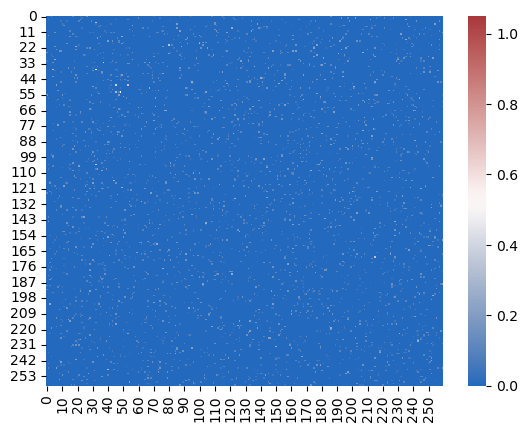

In [304]:
heatmap(W_ee_mg.todense(), cmap=color_palette("vlag", as_cmap=True))

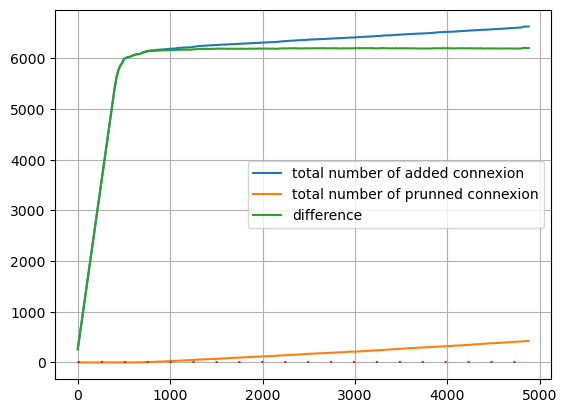

In [305]:
plt.figure()
plt.plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
plt.plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
plt.plot(np.arange(step)*INCREMENT, add-prun, label="difference")
plt.plot(np.arange(step)*INCREMENT, [0]*step, linestyle=(0, (1, 10)))
plt.legend()
plt.grid()

### Creating matrice from ADSP+Mackey Glass

In [306]:
from reservoir.reservoir import update_reservoir
from reservoir.reservoir import init_matrices
from connexion_generation.bounded_adsp import bounded_adsp
from connexion_generation.utility import compute_synaptic_change

# Initialisation EE
Win_4, W_4, bias_4 =  init_matrices(n, 1, 0, spectral_radius, seed=SEED)
bias_4 = bias_4*bias_scaling
Win_4= Win_4*input_scaling

# initial state
state_4 = np.random.uniform(0, 1, n)


target_rate = 0.8 #  0.9 show good results as well
growth_parameter = 0.1

step=0
state_history_4 = []
total_added = 0
total_pruned = 0
add = []
prun = []

for i in range(INCREMENT*5):
    state_4 = update_reservoir(W_4, Win_4, mg_inputs[i], state_4, leaky_rate, bias_4, activation_function)
    state_history_4.append(state_4)
mg_inputs = mg_inputs[INCREMENT * 5:]


In [307]:
train_length = len(mg_inputs[:])
while train_length > 5000:
    delta_z = compute_synaptic_change(state_history_4[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
    W_4, _, nb_new_add, nb_new_prun = bounded_adsp(W_4, state_4, delta_z, VALUE)

    for i in range(INCREMENT):
        state_4 = update_reservoir(W_4, Win_4, mg_inputs[i], state_4, leaky_rate, bias_4, activation_function)
        state_history_4.append(state_4)
    mg_inputs = mg_inputs[INCREMENT:]

    train_length = len(mg_inputs[:])
    
    total_added += nb_new_add
    total_pruned += nb_new_prun
    add.append(total_added)
    prun.append(total_pruned)

    step += 1
add = np.array(add)
prun = np.array(prun)

<AxesSubplot: >

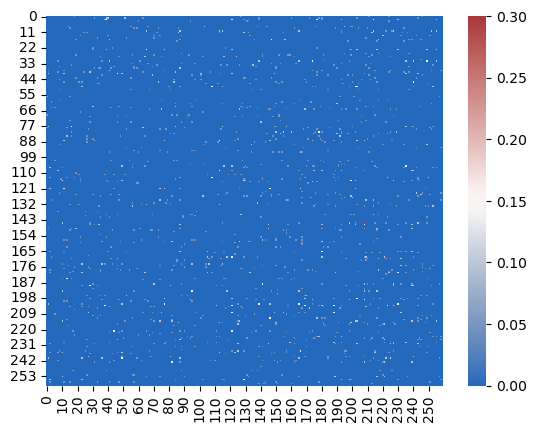

In [308]:
heatmap(W_4.todense(), cmap=color_palette("vlag", as_cmap=True))

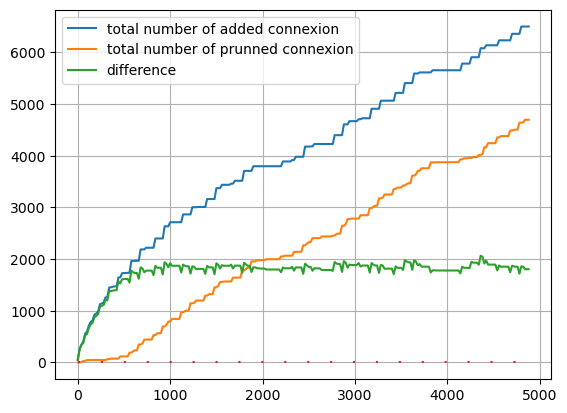

In [309]:
plt.figure()
plt.plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
plt.plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
plt.plot(np.arange(step)*INCREMENT, add-prun, label="difference")
plt.plot(np.arange(step)*INCREMENT, [0]*step, linestyle=(0, (1, 10)))
plt.legend()
plt.grid()

### Other matrice

In [310]:
from scipy import stats

# We generate a network randomly with same spectral radius and same connectivity as the ADSP generated one
connectivity_mg =  W_ee_mg.count_nonzero() / (W_ee_mg.shape[0] * W_ee_mg.shape[1])
eigen_adsp = sparse.linalg.eigs(W_ee_mg, k=1, which="LM", maxiter=W_ee_mg.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_adsp = max(abs(eigen_adsp))

# 3rd (normal + band)
Win_3, W_3, bias_3 =  init_matrices(n, 1, connectivity_mg, spectral_radius)
bias_3= bias_3*bias_scaling
Win_3= Win_3*0.3

eigen_3 = sparse.linalg.eigs(W_3, k=1, which="LM", maxiter=W_3.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_3 = max(abs(eigen_3))
W_3 = W_3*sr_adsp/sr_3
eigen_3 = sparse.linalg.eigs(W_3, k=1, which="LM", maxiter=W_3.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_3 = max(abs(eigen_3))

# 4th
connectivity_4 =  W_4.count_nonzero() / (W_4.shape[0] * W_4.shape[1])
eigen_4 = sparse.linalg.eigs(W_4, k=1, which="LM", maxiter=W_4.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_4 = max(abs(eigen_4))

# The normal matrice
Win_normal, W_normal, bias_normal =  init_matrices(n, 1, connectivity_mg, spectral_radius)
bias_normal= bias_normal*bias_scaling
Win_normal= Win_normal*0.3


eigen_normal = sparse.linalg.eigs(W_normal, k=1, which="LM", maxiter=W_normal.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_normal = max(abs(eigen_normal))
W_normal = W_normal*sr_4/sr_normal
eigen_normal = sparse.linalg.eigs(W_normal, k=1, which="LM", maxiter=W_normal.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_normal = max(abs(eigen_normal))


In [311]:
Win_normal

<260x1 sparse matrix of type '<class 'numpy.float64'>'
	with 260 stored elements in COOrdinate format>

In [312]:
print(sr_adsp)
print(sr_3)

print(sr_4)
print(sr_normal)


1.2226805195186412
1.222680519816032
0.6658446962328658
0.6658446965753267


In [313]:
SR_NORMALIZED = 0.99
W_normal = W_normal*SR_NORMALIZED/sr_normal
W_ee_mg = W_ee_mg*SR_NORMALIZED/sr_adsp
W_4 = W_4*SR_NORMALIZED/sr_4
W_4 = W_4*SR_NORMALIZED/sr_4

### Performances

In [314]:
import reservoir.reservoir
from reservoir.reservoir import train_ei, train
reload(reservoir.reservoir)

ridge_coef = 1e-7
step_ahead = 30
# Training output ASDP + bandfilter
Wout_mg, b_out_mg, last_state_mg = train(W_ee_mg, Win_e_mg, bias_mg, frequency_bands[:, :4000], mg_inputs[step_ahead:4000 + step_ahead], activation_function, ridge_coef = ridge_coef)

# Training output
Wout_normal, b_out_normal, last_state_normal = train(W_normal, Win_normal, bias_normal, mg_inputs[:4000], mg_inputs[step_ahead:4000 + step_ahead], activation_function, ridge_coef = ridge_coef)

# Training output
Wout_3, b_out_3, last_state_3 = train(W_3, Win_3, bias_3, frequency_bands[:, :4000], mg_inputs[step_ahead:4000 + step_ahead], activation_function, ridge_coef = ridge_coef)

# Training output for ADSP + MG
Wout_4, b_out_4, last_state_4 = train(W_4, Win_4, bias_4, mg_inputs[:4000], mg_inputs[step_ahead:4000 + step_ahead], activation_function, ridge_coef = ridge_coef)


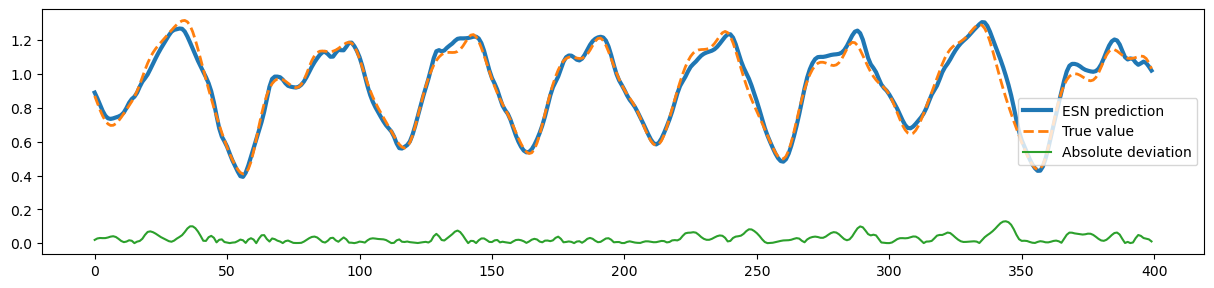

In [315]:
from reservoir.reservoir import run
reload(reservoir.reservoir)

from reservoir.reservoirpy_util import plot_results, plot_readout
np.zeros(2000)
frequency_bands[:,4000:5200]
mg_inputs[4000:5200]
# Prediction for ADSP + bandfilter
y_pred_mg = run(W_ee_mg, Win_e_mg, bias_mg, Wout_mg, frequency_bands[:,4000:5200], activation_function, b_out_mg, last_state_mg)

# Prediction for ADSP + MG
y_pred_4 = run(W_4, Win_4, bias_4, Wout_4, mg_inputs[4000:5200], activation_function, b_out_4, last_state_4)

# Prediction for random + bandfilter
y_pred_3 = run(W_3, Win_3, bias_3, Wout_3, frequency_bands[:,4000:5200], activation_function, b_out_3, last_state_3)

# Prediction for random + MG
y_pred_normal = run(W_normal, Win_normal, bias_normal, Wout_normal, mg_inputs[4000:5200], activation_function, b_out_normal, last_state_normal)


plot_results(y_pred_3, mg_inputs[4000+step_ahead:], sample=400)


In [316]:
import reservoir.losses
from reservoir.losses import rmse, nrmse
reload(reservoir.losses)

y_target = mg_inputs[4000 + step_ahead :4300 + step_ahead]
print("nrmse adsp + band   :", float(nrmse(y_target, y_pred_mg[:300])))
print("nrmse adsp + MG     :", float(nrmse(y_target, y_pred_4[:300])))
print("nrmse random + band :", float(nrmse(y_target, y_pred_3[:300])))
print("nrmse normal        :", float(nrmse(y_target, y_pred_normal[:300])))


nrmse adsp + band   : 0.06283442013193001
nrmse adsp + MG     : 0.5454009483154155
nrmse random + band : 0.14408251941083483
nrmse normal        : 0.5351616995470245


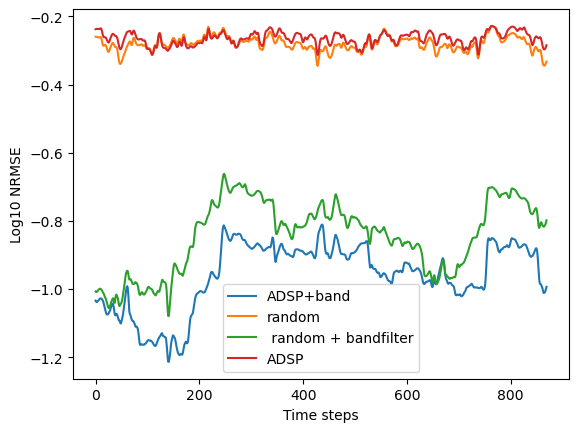

In [177]:
nrmse_array_mg = []
nrmse_array_normal = []
nrmse_array_3 = []
nrmse_array_4 = []

for i in range(len(y_pred_mg)-100- step_ahead):
    y_target_i = mg_inputs[4000 + step_ahead +i: 4100 + step_ahead +i]
    nrmse_array_mg.append(nrmse(y_target_i, y_pred_mg[i:100+i]))
    nrmse_array_normal.append(nrmse(y_target_i, y_pred_normal[i:100+i]))
    nrmse_array_3.append(nrmse(y_target_i, y_pred_3[i:100+i]))
    nrmse_array_4.append(nrmse(y_target_i, y_pred_4[i:100+i]))
    
log10_nrmse_mg = np.log10(nrmse_array_mg)
log10_nrmse_normal = np.log10(nrmse_array_normal)
log10_nrmse_3 = np.log10(nrmse_array_3)
log10_nrmse_4 = np.log10(nrmse_array_4)
plt.figure()
plt.plot(log10_nrmse_mg[:1000])
plt.plot(log10_nrmse_normal[:1000])
plt.plot(log10_nrmse_3[:1000])
plt.plot(log10_nrmse_4[:1000])
plt.xlabel('Time steps')
plt.ylabel('Log10 NRMSE')
plt.legend(["ADSP+band", "random", " random + bandfilter", "ADSP"])
plt.show()

In [178]:
# function to measure furthest predicted point based on RMSE
def furthest_predicted_point(y, y_pred, rmse_min):
    furthest_point = 0
    for i in range(len(y_pred)):
        rmse = np.sqrt(np.mean((y[i] - y_pred[i])**2))
        if rmse > rmse_min:
            furthest_point = i
    return furthest_point